# Cross-Cohort Signature Correspondence Analysis

This notebook quantifies the reproducibility of disease signatures across biobanks (UK Biobank, Mass General Brigham, All of Us) using:

1. **Cross-tabulation matrices**: Normalized confusion matrices showing cluster correspondence
2. **Modified Jaccard similarity**: Set-based metric for quantifying signature overlap

**Key metric**: Median modified Jaccard similarity = 0.800 (80.0%) across all UKB signatures


## Setup and Data Loading


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# Output directory
OUTPUT_DIR = Path('.')
OUTPUT_DIR.mkdir(exist_ok=True)

print("Setup complete")


Setup complete


In [4]:
mgb_checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt'

In [5]:
# Load model checkpoints
print("="*80)
print("LOADING MODEL CHECKPOINTS")
print("="*80)

ukb_checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt'
mgb_checkpoint_path = '/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam_MGB.pt'
aou_checkpoint_path = '/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam_AOU.pt'

ukb_checkpoint = torch.load(ukb_checkpoint_path, map_location='cpu')
mgb_checkpoint = torch.load(mgb_checkpoint_path, map_location='cpu')
aou_checkpoint = torch.load(aou_checkpoint_path, map_location='cpu')

print(f"\n✓ UKB checkpoint loaded")
print(f"✓ MGB checkpoint loaded")
print(f"✓ AoU checkpoint loaded")

# Extract disease names and clusters
ukb_diseases = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/disease_names.csv')['x']
mgb_diseases = mgb_checkpoint['disease_names']
aou_diseases = aou_checkpoint['disease_names']

ukb_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
mgb_clusters = mgb_checkpoint['clusters']
aou_clusters = aou_checkpoint['clusters']

# Convert to lists if needed
if hasattr(ukb_diseases, 'values'):
    ukb_diseases = ukb_diseases.values.tolist()
if hasattr(mgb_diseases, 'values'):
    mgb_diseases = mgb_diseases.values.tolist()
if hasattr(aou_diseases, 'values'):
    aou_diseases = aou_diseases.values.tolist()

# Convert clusters to numpy arrays if needed
if isinstance(ukb_clusters, torch.Tensor):
    ukb_clusters = ukb_clusters.numpy()
if isinstance(mgb_clusters, torch.Tensor):
    mgb_clusters = mgb_clusters.numpy()
if isinstance(aou_clusters, torch.Tensor):
    aou_clusters = aou_clusters.numpy()

print(f"\nUKB: {len(ukb_diseases)} diseases, {ukb_clusters.max()+1} signatures")
print(f"MGB: {len(mgb_diseases)} diseases, {mgb_clusters.max()+1} signatures")
print(f"AoU: {len(aou_diseases)} diseases, {aou_clusters.max()+1} signatures")


LOADING MODEL CHECKPOINTS

✓ UKB checkpoint loaded
✓ MGB checkpoint loaded
✓ AoU checkpoint loaded

UKB: 348 diseases, 20 signatures
MGB: 346 diseases, 20 signatures
AoU: 348 diseases, 20 signatures


## Create DataFrames and Find Common Diseases


In [6]:
# Create DataFrames for each biobank
ukb_df = pd.DataFrame({
    'Disease': ukb_diseases,
    'UKB_cluster': ukb_clusters
})

mgb_df = pd.DataFrame({
    'Disease': mgb_diseases,
    'MGB_cluster': mgb_clusters
})

aou_df = pd.DataFrame({
    'Disease': aou_diseases,
    'AoU_cluster': aou_clusters
})

# Find common diseases between biobanks
common_ukb_mgb = list(set(ukb_diseases) & set(mgb_diseases))
common_ukb_aou = list(set(ukb_diseases) & set(aou_diseases))
common_all_three = list(set(ukb_diseases) & set(mgb_diseases) & set(aou_diseases))

print("="*80)
print("COMMON DISEASES")
print("="*80)
print(f"\nUKB ↔ MGB: {len(common_ukb_mgb)} common diseases")
print(f"UKB ↔ AoU: {len(common_ukb_aou)} common diseases")
print(f"All three biobanks: {len(common_all_three)} common diseases")


COMMON DISEASES

UKB ↔ MGB: 346 common diseases
UKB ↔ AoU: 348 common diseases
All three biobanks: 346 common diseases


## Cross-Tabulation Matrices


In [7]:
# Create cross-tabulation matrices (normalized by row)
print("="*80)
print("CROSS-TABULATION MATRICES")
print("="*80)

# Merge dataframes for common diseases
df_ukb_mgb = pd.DataFrame({'Disease': common_ukb_mgb})
df_ukb_mgb = df_ukb_mgb.merge(ukb_df, on='Disease', how='left')
df_ukb_mgb = df_ukb_mgb.merge(mgb_df, on='Disease', how='left')

df_ukb_aou = pd.DataFrame({'Disease': common_ukb_aou})
df_ukb_aou = df_ukb_aou.merge(ukb_df, on='Disease', how='left')
df_ukb_aou = df_ukb_aou.merge(aou_df, on='Disease', how='left')

# Create cross-tabulation matrices (normalized by row)
cross_tab_mgb = pd.crosstab(
    df_ukb_mgb['UKB_cluster'], 
    df_ukb_mgb['MGB_cluster'], 
    normalize='index'
)

cross_tab_aou = pd.crosstab(
    df_ukb_aou['UKB_cluster'], 
    df_ukb_aou['AoU_cluster'], 
    normalize='index'
)

print(f"\n✓ Cross-tabulation matrix (UKB vs MGB): {cross_tab_mgb.shape}")
print(f"✓ Cross-tabulation matrix (UKB vs AoU): {cross_tab_aou.shape}")

# Find best matches for ordering
best_matches_mgb = pd.DataFrame({
    'UKB': cross_tab_mgb.index,
    'MGB': cross_tab_mgb.idxmax(axis=1),
    'Proportion': cross_tab_mgb.max(axis=1).values
}).sort_values('MGB')

best_matches_aou = pd.DataFrame({
    'UKB': cross_tab_aou.index,
    'AoU': cross_tab_aou.idxmax(axis=1),
    'Proportion': cross_tab_aou.max(axis=1).values
}).sort_values('AoU')

print(f"\n✓ Best matches identified for visualization")


CROSS-TABULATION MATRICES

✓ Cross-tabulation matrix (UKB vs MGB): (20, 20)
✓ Cross-tabulation matrix (UKB vs AoU): (20, 20)

✓ Best matches identified for visualization


## Calculate Modified Jaccard Similarity

The modified Jaccard similarity for each UKB cluster $k$ is defined as:

$$J_k = \\frac{|D_{k,\\text{UKB}} \\cap D_{k^*,\\text{other}}|}{|D_{k,\\text{UKB}}|}$$

where:
- $D_{k,\\text{UKB}}$ is the set of diseases in UKB cluster $k$
- $D_{k^*,\\text{other}}$ is the set of diseases in the best-matching cluster $k^*$ in the comparison cohort
- $|\\cdot|$ denotes set cardinality

The overall cross-cohort similarity is the **median** of these cluster-specific similarities.


In [8]:
def calculate_modified_jaccard(ukb_df, other_df, other_col_name, common_diseases, biobank_name):
    """
    Calculate modified Jaccard similarity using set intersections.
    
    For each UKB cluster k:
    1. Get set of diseases in UKB cluster k (from common diseases)
    2. For each cluster in other biobank, calculate intersection
    3. Find best-matching cluster (maximum intersection / UKB cluster size)
    4. Store Jaccard score for cluster k
    
    Returns:
    --------
    jaccard_scores : list
        List of Jaccard scores for each UKB cluster
    cluster_details : dict
        Dictionary with details for each cluster
    """
    # Merge on common diseases
    merged = ukb_df[ukb_df['Disease'].isin(common_diseases)].merge(
        other_df[other_df['Disease'].isin(common_diseases)],
        on='Disease', how='inner'
    )
    
    # Group by UKB cluster
    jaccard_scores = []
    cluster_details = {}
    
    for ukb_cluster in sorted(merged['UKB_cluster'].unique()):
        ukb_diseases = set(merged[merged['UKB_cluster'] == ukb_cluster]['Disease'])
        if len(ukb_diseases) == 0:
            continue
            
        # Find best matching cluster in other biobank
        best_match_score = 0
        best_match_cluster = None
        best_intersection = set()
        
        for other_cluster in sorted(merged[other_col_name].unique()):
            other_diseases = set(merged[merged[other_col_name] == other_cluster]['Disease'])
            intersection = ukb_diseases & other_diseases
            jaccard_k = len(intersection) / len(ukb_diseases)
            
            if jaccard_k > best_match_score:
                best_match_score = jaccard_k
                best_match_cluster = other_cluster
                best_intersection = intersection
        
        jaccard_scores.append(best_match_score)
        cluster_details[ukb_cluster] = {
            'jaccard': best_match_score,
            'best_match': best_match_cluster,
            'ukb_size': len(ukb_diseases),
            'intersection_size': len(best_intersection)
        }
        
        print(f"  UKB cluster {ukb_cluster:2d} → {biobank_name} cluster {best_match_cluster:2d}: "
              f"J = {best_match_score:.3f} ({len(best_intersection)}/{len(ukb_diseases)} diseases)")
    
    return jaccard_scores, cluster_details

print("="*80)
print("MODIFIED JACCARD SIMILARITY CALCULATION")
print("="*80)

print("\n" + "-"*80)
print("UKB ↔ MGB:")
print("-"*80)
jaccard_mgb, details_mgb = calculate_modified_jaccard(
    ukb_df, mgb_df, 'MGB_cluster', common_ukb_mgb, 'MGB'
)

print("\n" + "-"*80)
print("UKB ↔ AoU:")
print("-"*80)
jaccard_aou, details_aou = calculate_modified_jaccard(
    ukb_df, aou_df, 'AoU_cluster', common_ukb_aou, 'AoU'
)

# Calculate summary statistics
median_mgb = np.median(jaccard_mgb)
median_aou = np.median(jaccard_aou)
combined_median = np.median(jaccard_mgb + jaccard_aou)
average_medians = (median_mgb + median_aou) / 2

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nMedian Jaccard (UKB ↔ MGB): {median_mgb:.3f} ({median_mgb*100:.1f}%)")
print(f"Median Jaccard (UKB ↔ AoU): {median_aou:.3f} ({median_aou*100:.1f}%)")
print(f"\nCombined median Jaccard: {combined_median:.3f} ({combined_median*100:.1f}%)")
print(f"Average of medians: {average_medians:.3f} ({average_medians*100:.1f}%)")
print(f"\nIQR (UKB ↔ MGB): [{np.percentile(jaccard_mgb, 25):.3f}, {np.percentile(jaccard_mgb, 75):.3f}]")
print(f"IQR (UKB ↔ AoU): [{np.percentile(jaccard_aou, 25):.3f}, {np.percentile(jaccard_aou, 75):.3f}]")


MODIFIED JACCARD SIMILARITY CALCULATION

--------------------------------------------------------------------------------
UKB ↔ MGB:
--------------------------------------------------------------------------------
  UKB cluster  0 → MGB cluster  5: J = 0.929 (13/14 diseases)
  UKB cluster  1 → MGB cluster  2: J = 0.952 (20/21 diseases)
  UKB cluster  2 → MGB cluster  7: J = 0.933 (14/15 diseases)
  UKB cluster  3 → MGB cluster 12: J = 0.561 (46/82 diseases)
  UKB cluster  4 → MGB cluster  0: J = 1.000 (5/5 diseases)
  UKB cluster  5 → MGB cluster  5: J = 0.571 (4/7 diseases)
  UKB cluster  6 → MGB cluster 11: J = 0.875 (7/8 diseases)
  UKB cluster  7 → MGB cluster  1: J = 0.500 (11/22 diseases)
  UKB cluster  8 → MGB cluster 19: J = 0.679 (19/28 diseases)
  UKB cluster  9 → MGB cluster  9: J = 1.000 (12/12 diseases)
  UKB cluster 10 → MGB cluster 16: J = 1.000 (11/11 diseases)
  UKB cluster 11 → MGB cluster 10: J = 0.875 (7/8 diseases)
  UKB cluster 12 → MGB cluster  3: J = 0.714 (5/7 

✓ Saved heatmaps to: cross_cohort_correspondence_heatmaps.pdf


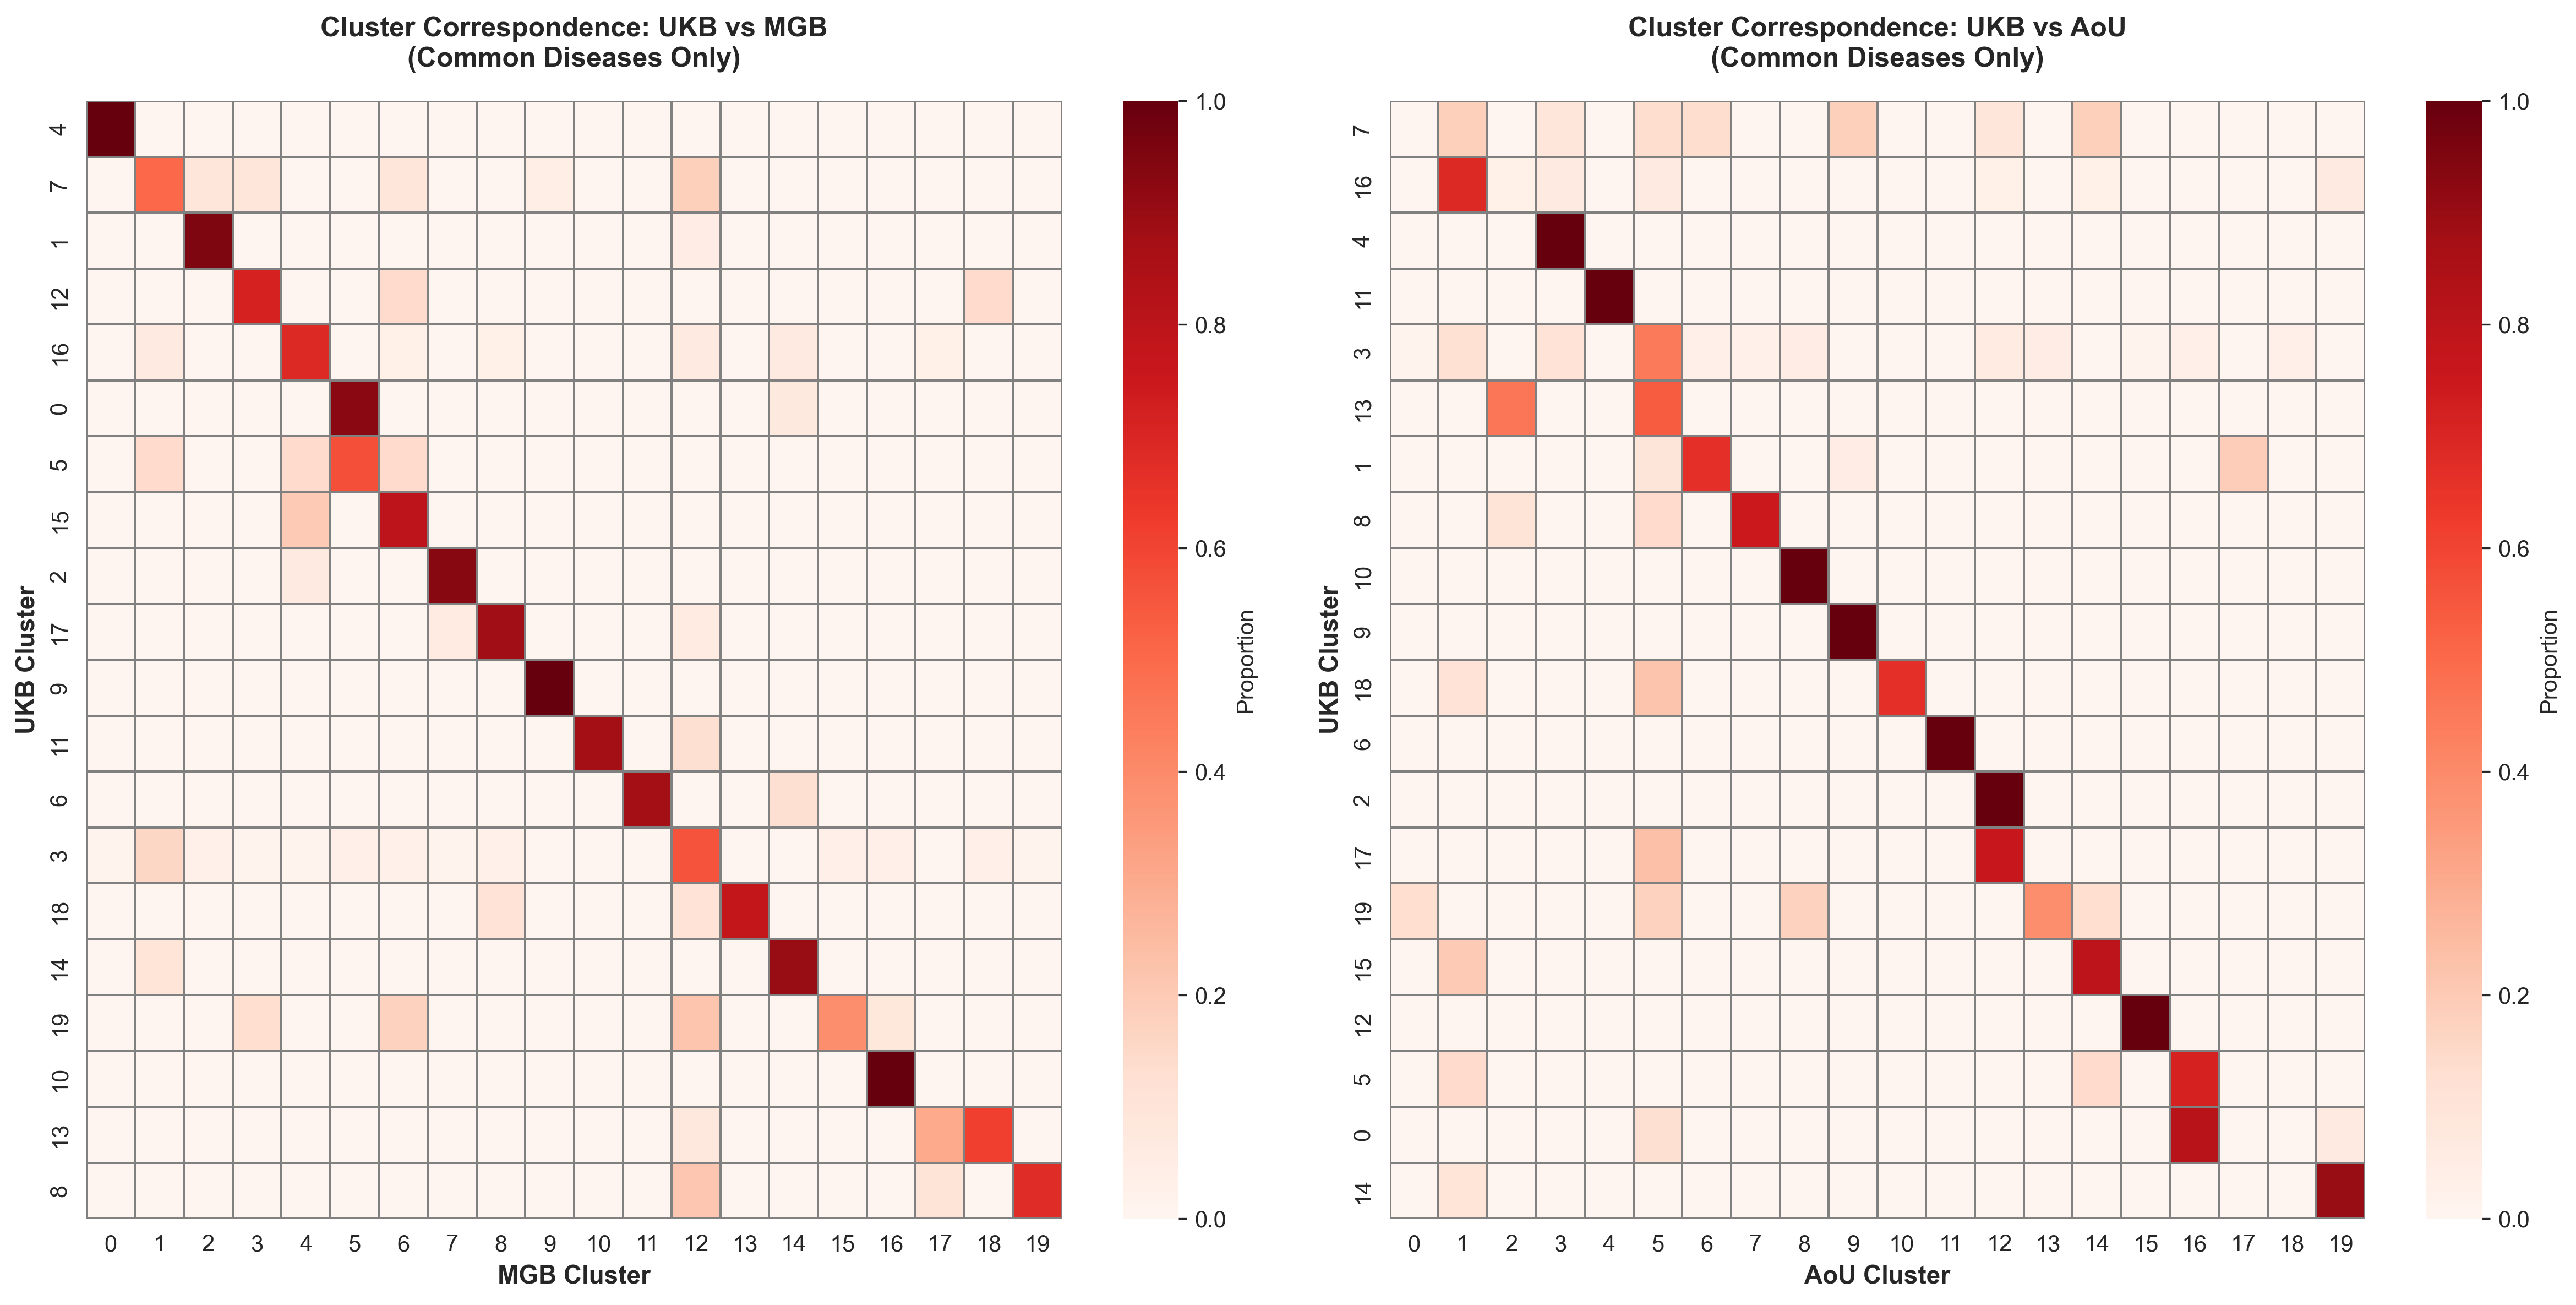

In [9]:
# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# UKB vs MGB
sns.heatmap(
    cross_tab_mgb.loc[best_matches_mgb['UKB']],
    cmap='Reds',
    vmin=0, vmax=1,
    ax=ax1,
    cbar_kws={'label': 'Proportion'},
    linewidths=0.5,
    linecolor='gray'
)
ax1.set_title('Cluster Correspondence: UKB vs MGB\n(Common Diseases Only)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.set_xlabel('MGB Cluster', fontsize=11, fontweight='bold')
ax1.set_ylabel('UKB Cluster', fontsize=11, fontweight='bold')

# UKB vs AoU
sns.heatmap(
    cross_tab_aou.loc[best_matches_aou['UKB']],
    cmap='Reds',
    vmin=0, vmax=1,
    ax=ax2,
    cbar_kws={'label': 'Proportion'},
    linewidths=0.5,
    linecolor='gray'
)
ax2.set_title('Cluster Correspondence: UKB vs AoU\n(Common Diseases Only)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.set_xlabel('AoU Cluster', fontsize=11, fontweight='bold')
ax2.set_ylabel('UKB Cluster', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cross_cohort_correspondence_heatmaps.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'cross_cohort_correspondence_heatmaps.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved heatmaps to: {OUTPUT_DIR / 'cross_cohort_correspondence_heatmaps.pdf'}")
plt.show()


### 2. Jaccard Similarity by Cluster


✓ Saved bar plots to: jaccard_similarity_by_cluster.pdf


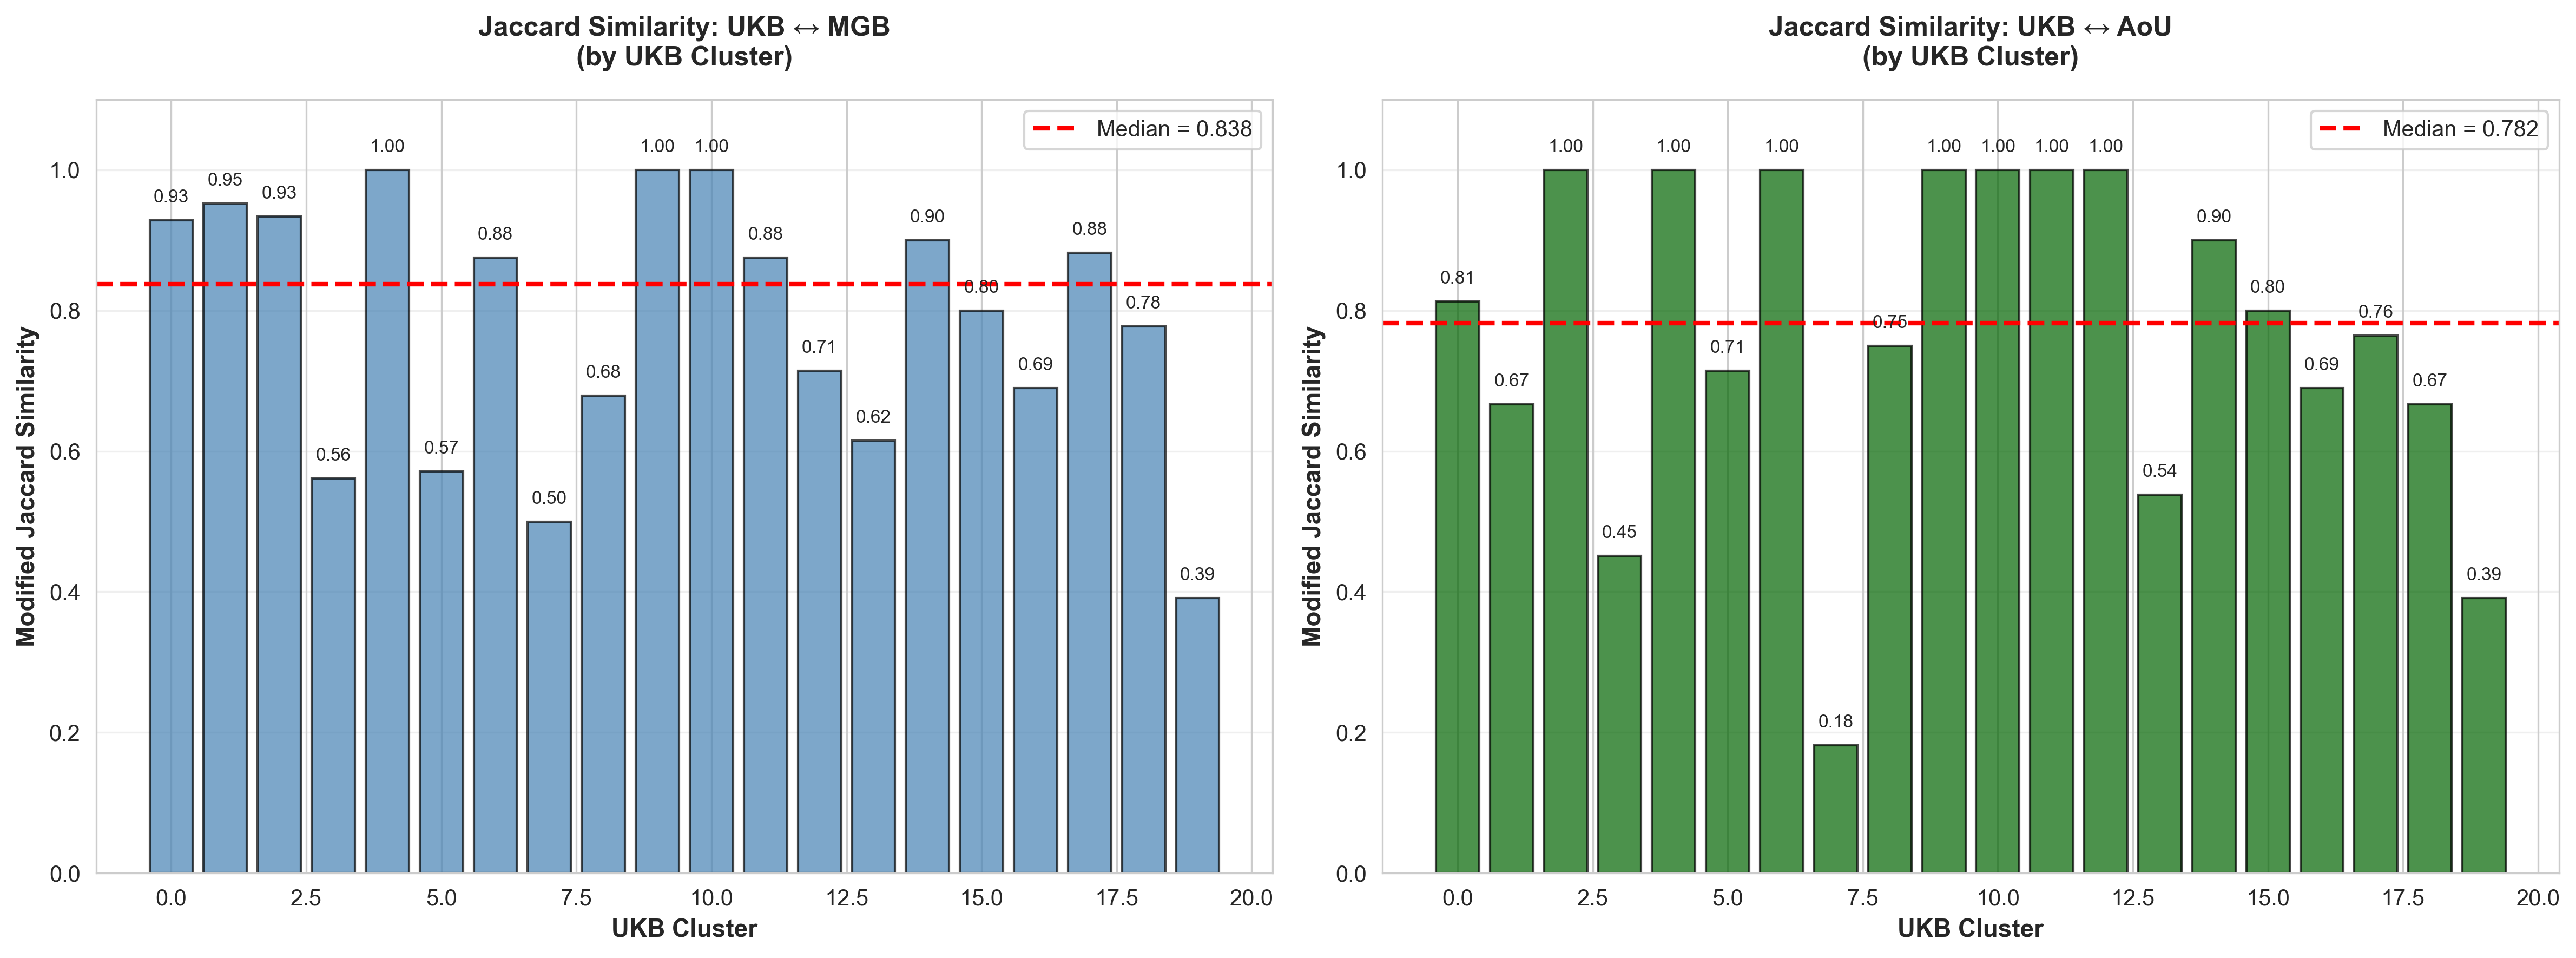

In [10]:
# Create bar plot of Jaccard similarities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data
ukb_clusters_mgb = sorted([k for k in details_mgb.keys()])
jaccard_values_mgb = [details_mgb[k]['jaccard'] for k in ukb_clusters_mgb]

ukb_clusters_aou = sorted([k for k in details_aou.keys()])
jaccard_values_aou = [details_aou[k]['jaccard'] for k in ukb_clusters_aou]

# UKB vs MGB
bars1 = ax1.bar(ukb_clusters_mgb, jaccard_values_mgb, 
                color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
ax1.axhline(y=median_mgb, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {median_mgb:.3f}')
ax1.set_xlabel('UKB Cluster', fontsize=11, fontweight='bold')
ax1.set_ylabel('Modified Jaccard Similarity', fontsize=11, fontweight='bold')
ax1.set_title('Jaccard Similarity: UKB ↔ MGB\n(by UKB Cluster)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.set_ylim([0, 1.1])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, jaccard_values_mgb)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=8)

# UKB vs AoU
bars2 = ax2.bar(ukb_clusters_aou, jaccard_values_aou, 
                color='darkgreen', alpha=0.7, edgecolor='black', linewidth=1)
ax2.axhline(y=median_aou, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {median_aou:.3f}')
ax2.set_xlabel('UKB Cluster', fontsize=11, fontweight='bold')
ax2.set_ylabel('Modified Jaccard Similarity', fontsize=11, fontweight='bold')
ax2.set_title('Jaccard Similarity: UKB ↔ AoU\n(by UKB Cluster)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.set_ylim([0, 1.1])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, jaccard_values_aou)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_by_cluster.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_by_cluster.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved bar plots to: {OUTPUT_DIR / 'jaccard_similarity_by_cluster.pdf'}")
plt.show()


### 3. Distribution of Jaccard Similarities


✓ Saved distribution plot to: jaccard_similarity_distribution.pdf


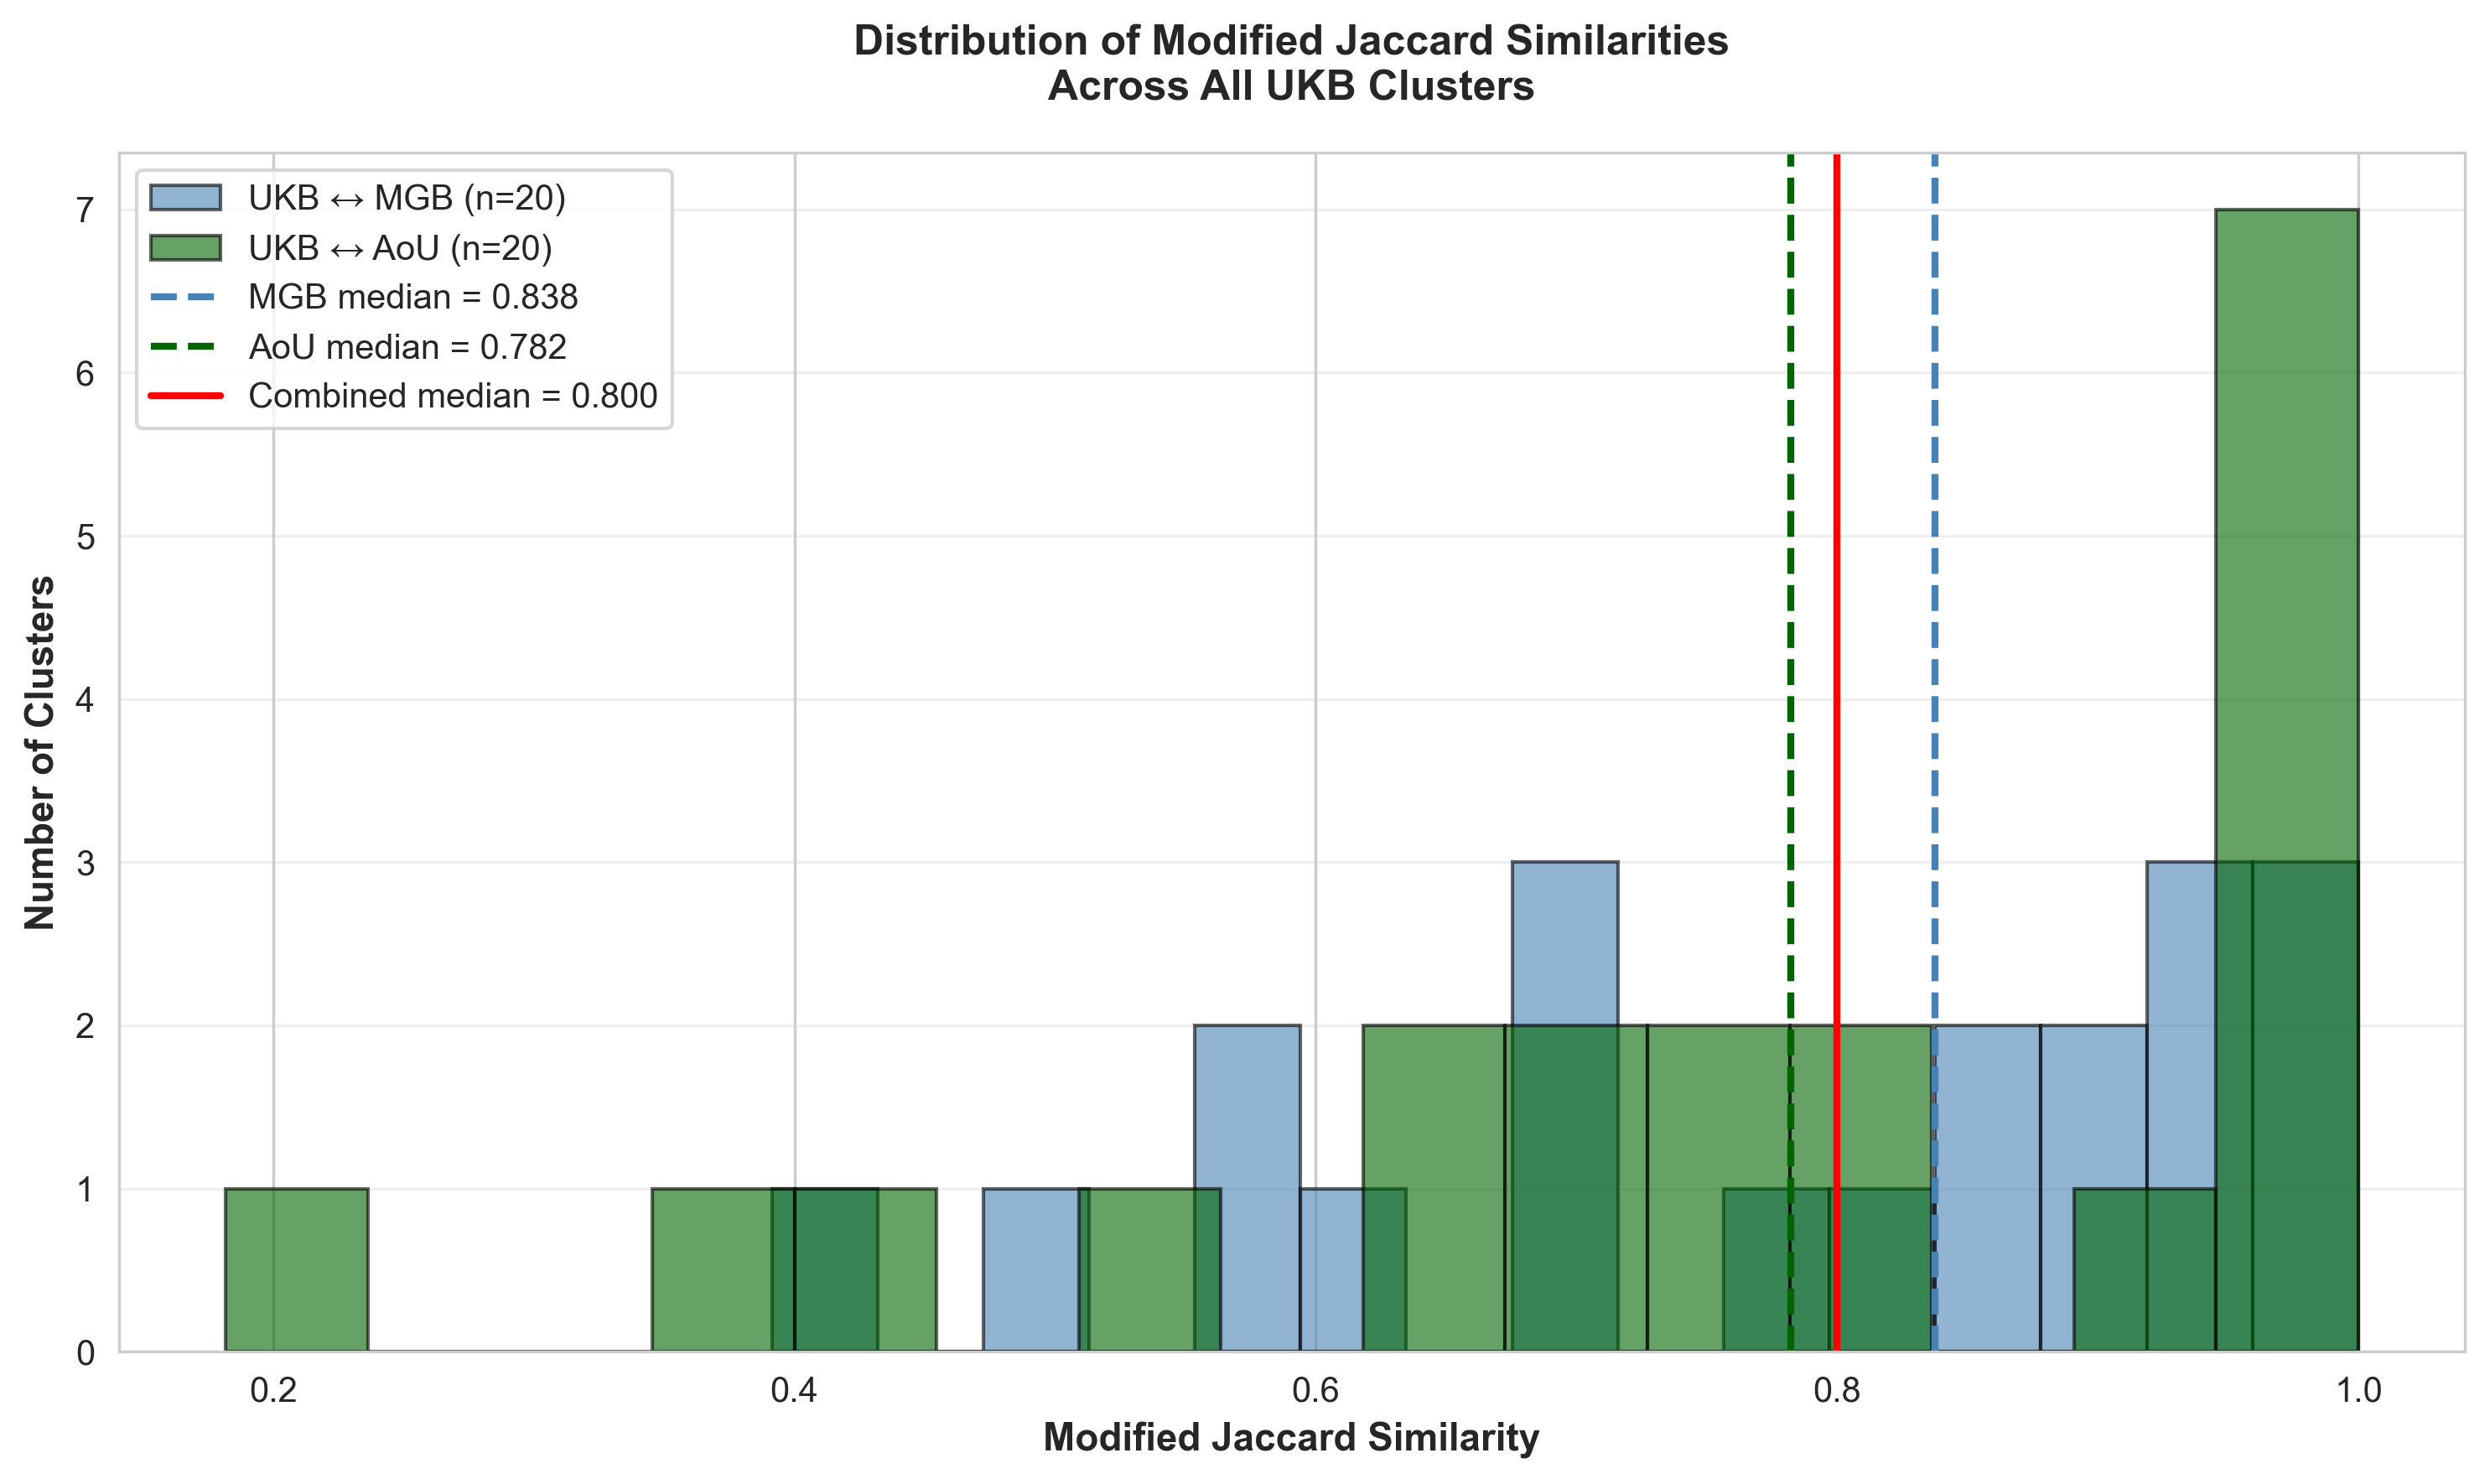

In [11]:
# Create distribution plot
fig, ax = plt.subplots(figsize=(10, 6))

# Combine all Jaccard scores
all_jaccard = jaccard_mgb + jaccard_aou

# Create histogram with KDE
ax.hist(jaccard_mgb, bins=15, alpha=0.6, label=f'UKB ↔ MGB (n={len(jaccard_mgb)})', 
        color='steelblue', edgecolor='black', linewidth=1)
ax.hist(jaccard_aou, bins=15, alpha=0.6, label=f'UKB ↔ AoU (n={len(jaccard_aou)})', 
        color='darkgreen', edgecolor='black', linewidth=1)

# Add median lines
ax.axvline(x=median_mgb, color='steelblue', linestyle='--', linewidth=2, 
           label=f'MGB median = {median_mgb:.3f}')
ax.axvline(x=median_aou, color='darkgreen', linestyle='--', linewidth=2, 
           label=f'AoU median = {median_aou:.3f}')
ax.axvline(x=combined_median, color='red', linestyle='-', linewidth=2, 
           label=f'Combined median = {combined_median:.3f}')

ax.set_xlabel('Modified Jaccard Similarity', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Clusters', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Modified Jaccard Similarities\nAcross All UKB Clusters', 
              fontsize=12, fontweight='bold', pad=15)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_distribution.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_distribution.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved distribution plot to: {OUTPUT_DIR / 'jaccard_similarity_distribution.pdf'}")
plt.show()


In [12]:
# Create summary table
summary_data = {
    'Comparison': ['UKB ↔ MGB', 'UKB ↔ AoU', 'Combined'],
    'Median Jaccard': [f'{median_mgb:.3f}', f'{median_aou:.3f}', f'{combined_median:.3f}'],
    'Median %': [f'{median_mgb*100:.1f}%', f'{median_aou*100:.1f}%', f'{combined_median*100:.1f}%'],
    'IQR': [
        f"[{np.percentile(jaccard_mgb, 25):.3f}, {np.percentile(jaccard_mgb, 75):.3f}]",
        f"[{np.percentile(jaccard_aou, 25):.3f}, {np.percentile(jaccard_aou, 75):.3f}]",
        f"[{np.percentile(all_jaccard, 25):.3f}, {np.percentile(all_jaccard, 75):.3f}]"
    ],
    'N Clusters': [len(jaccard_mgb), len(jaccard_aou), len(all_jaccard)],
    'Common Diseases': [len(common_ukb_mgb), len(common_ukb_aou), len(common_all_three)]
}

summary_df = pd.DataFrame(summary_data)
print("="*80)
print("SUMMARY TABLE")
print("="*80)
print("\n", summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(OUTPUT_DIR / 'cross_cohort_similarity_summary.csv', index=False)
print(f"\n✓ Saved summary table to: {OUTPUT_DIR / 'cross_cohort_similarity_summary.csv'}")


SUMMARY TABLE

 Comparison Median Jaccard Median %            IQR  N Clusters  Common Diseases
 UKB ↔ MGB          0.838    83.8% [0.663, 0.930]          20              346
 UKB ↔ AoU          0.782    78.2% [0.667, 1.000]          20              348
  Combined          0.800    80.0% [0.667, 0.964]          40              346

✓ Saved summary table to: cross_cohort_similarity_summary.csv


## Alternative Analysis: Psi-Based Similarity

**Giovanni's concern:** The initial cluster designation doesn't recognize the fit and treats all diseases equally (doesn't weight by cluster-specific affinity).

**Solution:** Use posterior psi (ψ) from fitted models, which captures the strength of disease-signature associations learned during training.

**Approach:**
- Load and average psi across batches for each cohort
- Compute similarity between cohorts based on psi matrices (using cosine similarity or correlation)
- Create heatmaps showing psi-based signature correspondence
- This weights diseases by their association strength with each signature, rather than treating all diseases equally


In [21]:
def calculate_weighted_modified_jaccard(ukb_psi, other_psi, ukb_clusters, other_clusters, 
                                       ukb_disease_names, other_disease_names, 
                                       common_diseases, biobank_name):
    """
    Calculate weighted modified Jaccard similarity using cluster assignments weighted by psi coefficients.
    
    For each UKB cluster k:
    1. Get set of diseases in UKB cluster k (from common diseases)
    2. For each cluster in other biobank, calculate weighted intersection
    3. Weight by psi coefficients: stronger associations contribute more
    4. Find best-matching cluster (maximum weighted intersection / weighted UKB cluster size)
    
    Returns:
    --------
    weighted_jaccard_scores : list
        List of weighted Jaccard scores for each UKB cluster
    cluster_details : dict
        Dictionary with details for each cluster
    """
    # Create disease name to index mapping
    ukb_disease_to_idx = {d: i for i, d in enumerate(ukb_disease_names)}
    other_disease_to_idx = {d: i for i, d in enumerate(other_disease_names)}
    
    # Create mapping: common disease name -> (ukb_idx, other_idx)
    disease_mapping = {}
    for d in common_diseases:
        if d in ukb_disease_to_idx and d in other_disease_to_idx:
            disease_mapping[d] = (ukb_disease_to_idx[d], other_disease_to_idx[d])
    
    weighted_jaccard_scores = []
    cluster_details = {}
    
    # Get unique UKB clusters
    ukb_unique_clusters = sorted(set(ukb_clusters))
    
    for ukb_sig in ukb_unique_clusters:
        # Get diseases in UKB signature (only common diseases)
        ukb_sig_diseases = []
        for d, (ukb_idx, other_idx) in disease_mapping.items():
            if ukb_clusters[ukb_idx] == ukb_sig:
                ukb_sig_diseases.append((d, ukb_idx, other_idx))
        
        if len(ukb_sig_diseases) == 0:
            continue
        
        # Calculate weighted size of UKB signature (sum of psi values)
        ukb_weighted_size = sum(ukb_psi[ukb_sig, ukb_idx] for d, ukb_idx, other_idx in ukb_sig_diseases)
        
        if ukb_weighted_size == 0:
            continue
        
        # Find best matching cluster in other biobank
        best_match_score = 0
        best_match_cluster = None
        best_weighted_overlap = 0
        
        # Get unique clusters in other biobank
        other_unique_clusters = sorted(set(other_clusters))
        
        for other_sig in other_unique_clusters:
            # Calculate weighted overlap: sum of psi values for diseases in both signatures
            weighted_overlap = 0
            weighted_ukb_only = ukb_weighted_size  # Start with UKB signature weighted size
            
            for d, ukb_idx, other_idx in ukb_sig_diseases:
                if other_clusters[other_idx] == other_sig:
                    # Disease is in overlap: add both psi values
                    weighted_overlap += (ukb_psi[ukb_sig, ukb_idx] + other_psi[other_sig, other_idx])
                    weighted_ukb_only -= ukb_psi[ukb_sig, ukb_idx]  # Remove from UKB-only count
            
            # Add diseases only in other signature
            weighted_other_only = 0
            for d, (ukb_idx, other_idx) in disease_mapping.items():
                if other_clusters[other_idx] == other_sig and ukb_clusters[ukb_idx] != ukb_sig:
                    weighted_other_only += other_psi[other_sig, other_idx]
            
            # Weighted union = weighted_overlap + weighted_ukb_only + weighted_other_only
            weighted_union = weighted_overlap + weighted_ukb_only + weighted_other_only
            
            # Weighted Jaccard: weighted_overlap / weighted_union
            if weighted_union > 0:
                weighted_jaccard = weighted_overlap / weighted_union
            else:
                weighted_jaccard = 0.0
            
            # Use intersection over UKB size (like original modified Jaccard)
            # Weighted overlap divided by 2*ukb_weighted_size (since overlap has both psi values)
            weighted_jaccard_over_ukb = weighted_overlap / (2 * ukb_weighted_size) if ukb_weighted_size > 0 else 0.0
            
            # Use the intersection/UKB version to match original modified Jaccard logic
            if weighted_jaccard_over_ukb > best_match_score:
                best_match_score = weighted_jaccard_over_ukb
                best_match_cluster = other_sig
                best_weighted_overlap = weighted_overlap
        
        weighted_jaccard_scores.append(best_match_score)
        cluster_details[ukb_sig] = {
            'weighted_jaccard': best_match_score,
            'best_match': best_match_cluster,
            'weighted_overlap': best_weighted_overlap,
            'ukb_weighted_size': ukb_weighted_size
        }
    
    return weighted_jaccard_scores, cluster_details

## try the average phi over time, and order 0-20
# composition preservation probability 

GIOVANNI'S WEIGHTED COEFFICIENT OVERLAP ANALYSIS

1. Loading UKB psi (pooled from batches)...
  Found 40 files matching pattern: enrollment_model_W0.0001_batch_*_*.pt
  ✓ Pooled 40 batches: shape (21, 348)

UKB Psi Summary:
  Shape: (21, 348)
  Min: -5.2067
  Max: 1.8672
  Mean: -2.1014
  Median: -2.0473
  Std: 0.8253

2. Loading AoU psi (pooled from batches)...
  Found 25 files matching pattern: aou_model_batch_*.pt
  ✓ Pooled 25 batches: shape (21, 348)

AoU Psi Summary:
  Shape: (21, 348)
  Min: -5.0487
  Max: 2.8246
  Mean: -2.0600
  Median: -2.0262
  Std: 0.9735

3. Loading MGB psi (from checkpoint)...

MGB Psi Summary:
  Shape: (21, 346)
  Min: -5.1884
  Max: 3.4834
  Mean: -2.0386
  Median: -2.0432
  Std: 1.0410

4a. Loading UKB phi (pooled from batches, time-averaged)...
  Found 40 files matching pattern: enrollment_model_W0.0001_batch_*_*.pt
  ✓ Pooled 40 batches: phi shape (21, 348, 52), time-averaged shape (21, 348)

4b. Loading AoU phi (pooled from batches, time-averaged)..

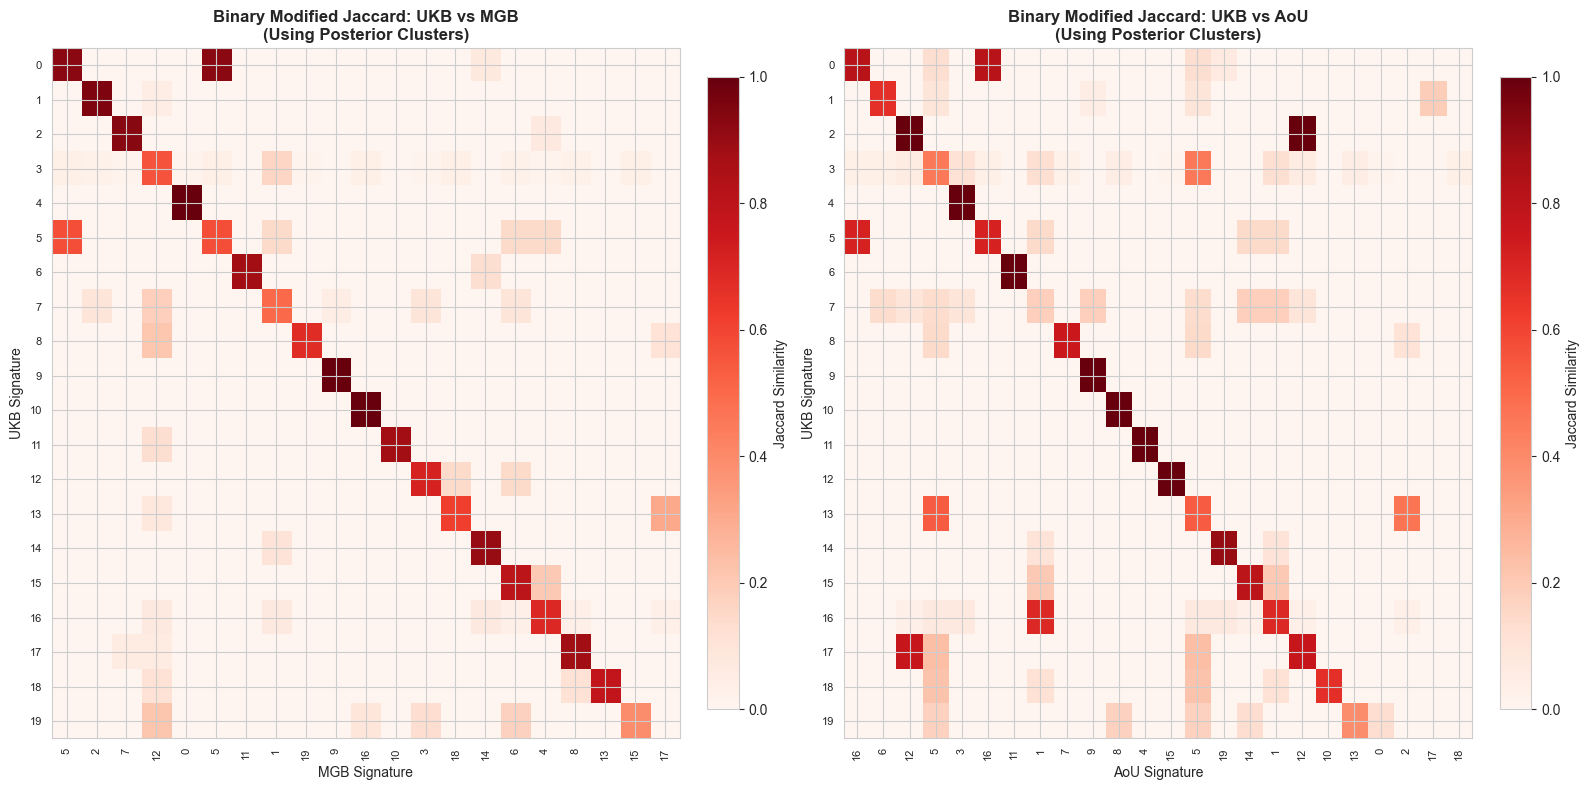


  Plotting binary Jaccard heatmaps (initial vs posterior)...
    ✓ Saved comparison heatmaps to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/reviewer_responses/notebooks/R3/binary_jaccard_comparison_heatmaps.pdf


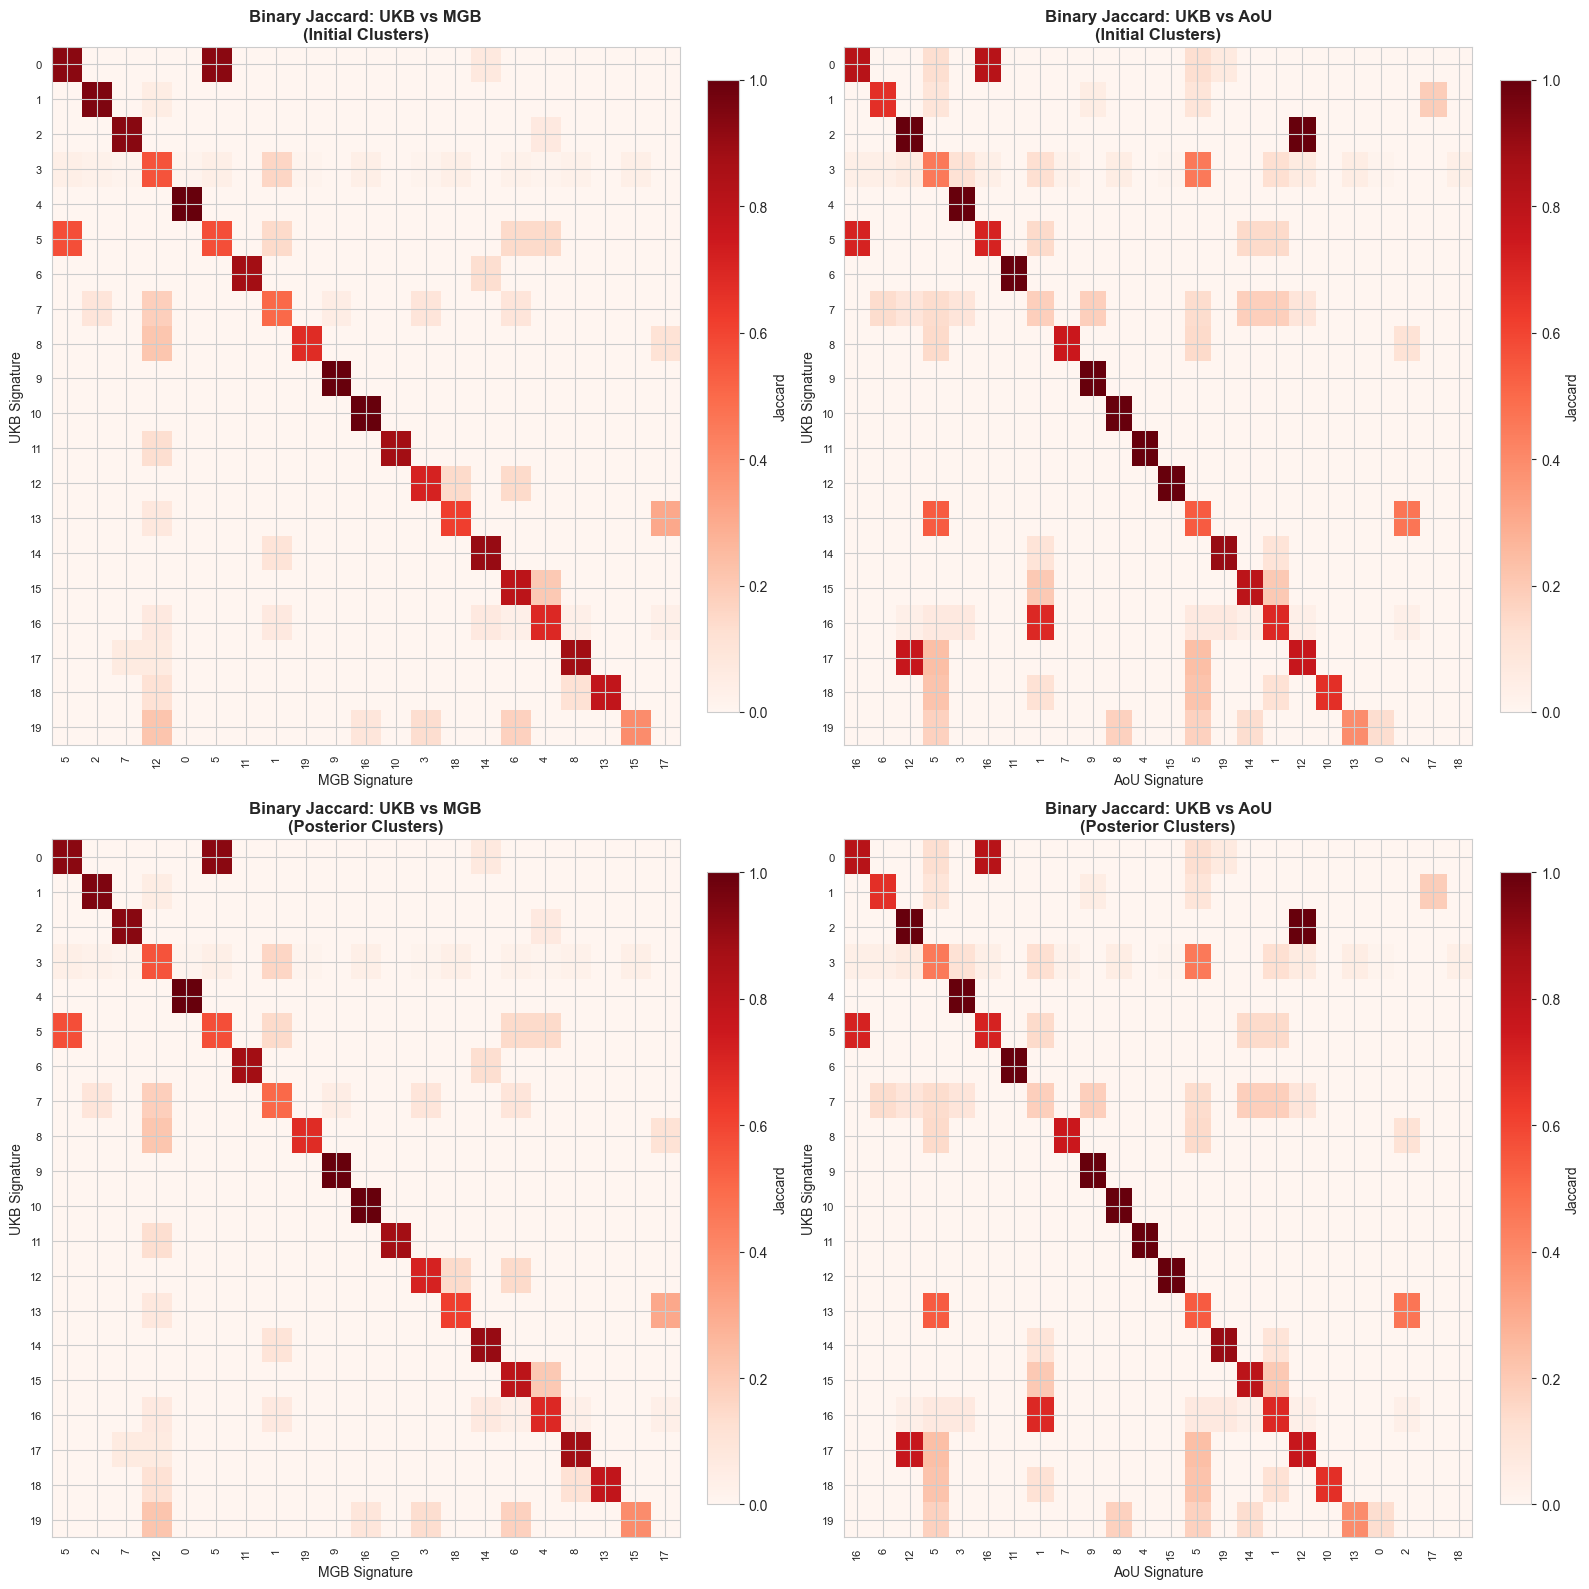


EXPERIMENT 2: WEIGHTED OVERLAP USING NORMALIZED PSI (SIGMOID)

  Formula:
    Weighted Overlap(UKB_sig_k, Other_sig_k') = 
        Σ_{d ∈ overlap} sigmoid(ψ_{k,d}) / Σ_{d ∈ UKB_sig_k} sigmoid(ψ_{k,d})

  where:
    - overlap = diseases in both UKB signature k and Other signature k'
    - UKB_sig_k = all diseases assigned to UKB signature k
    - sigmoid(ψ_{k,d}) = expit(ψ_{k,d}) = 1 / (1 + exp(-ψ_{k,d}))
    - This metric is bounded to [0, 1]

  UKB ↔ MGB:
    Similarity matrix shape: (21, 21)
    Range: [0.0000, 1.0000]
    Median best match: 0.8005

  UKB ↔ AoU:
    Similarity matrix shape: (21, 21)
    Range: [0.0000, 1.0000]
    Median best match: 0.7159

ORIGINAL: WEIGHTED OVERLAP USING RAW PSI

  UKB ↔ MGB:

  UKB ↔ MGB:
    Similarity matrix shape: (21, 21)
    Range: [-0.5310, 1.2985]
    Median best match: 0.8005

  UKB ↔ AoU:
    Similarity matrix shape: (21, 21)
    Range: [-1.1193, 2.1193]
    Median best match: 0.6843

EXPERIMENT 3: WEIGHTED OVERLAP USING TIME-AVERAGED PH

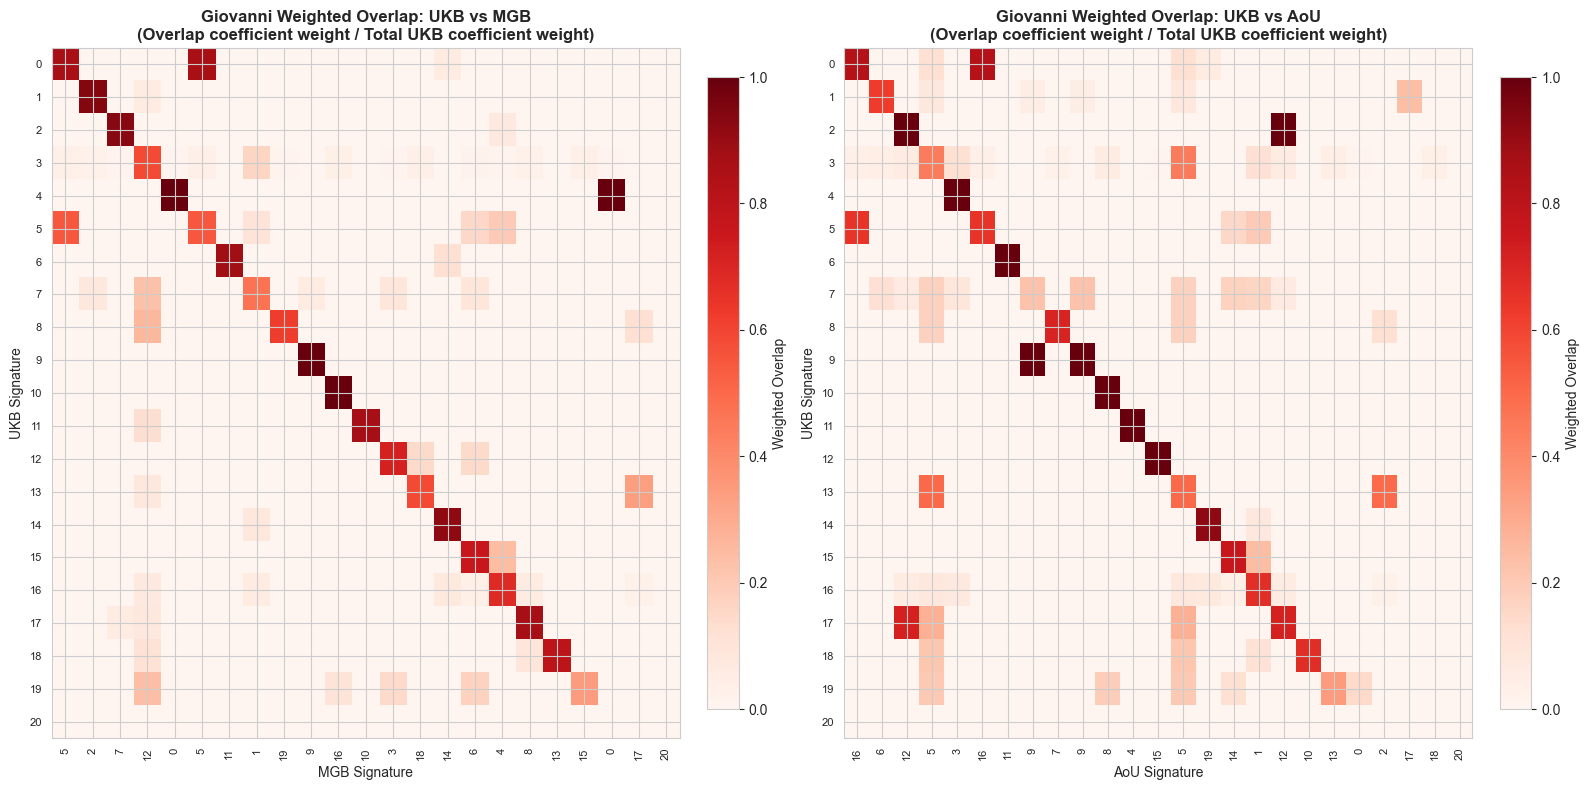


9b. Plotting heatmaps (time-averaged phi version)...

✓ Saved heatmap to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/reviewer_responses/notebooks/R3/giovanni_weighted_overlap_phi_heatmaps.pdf


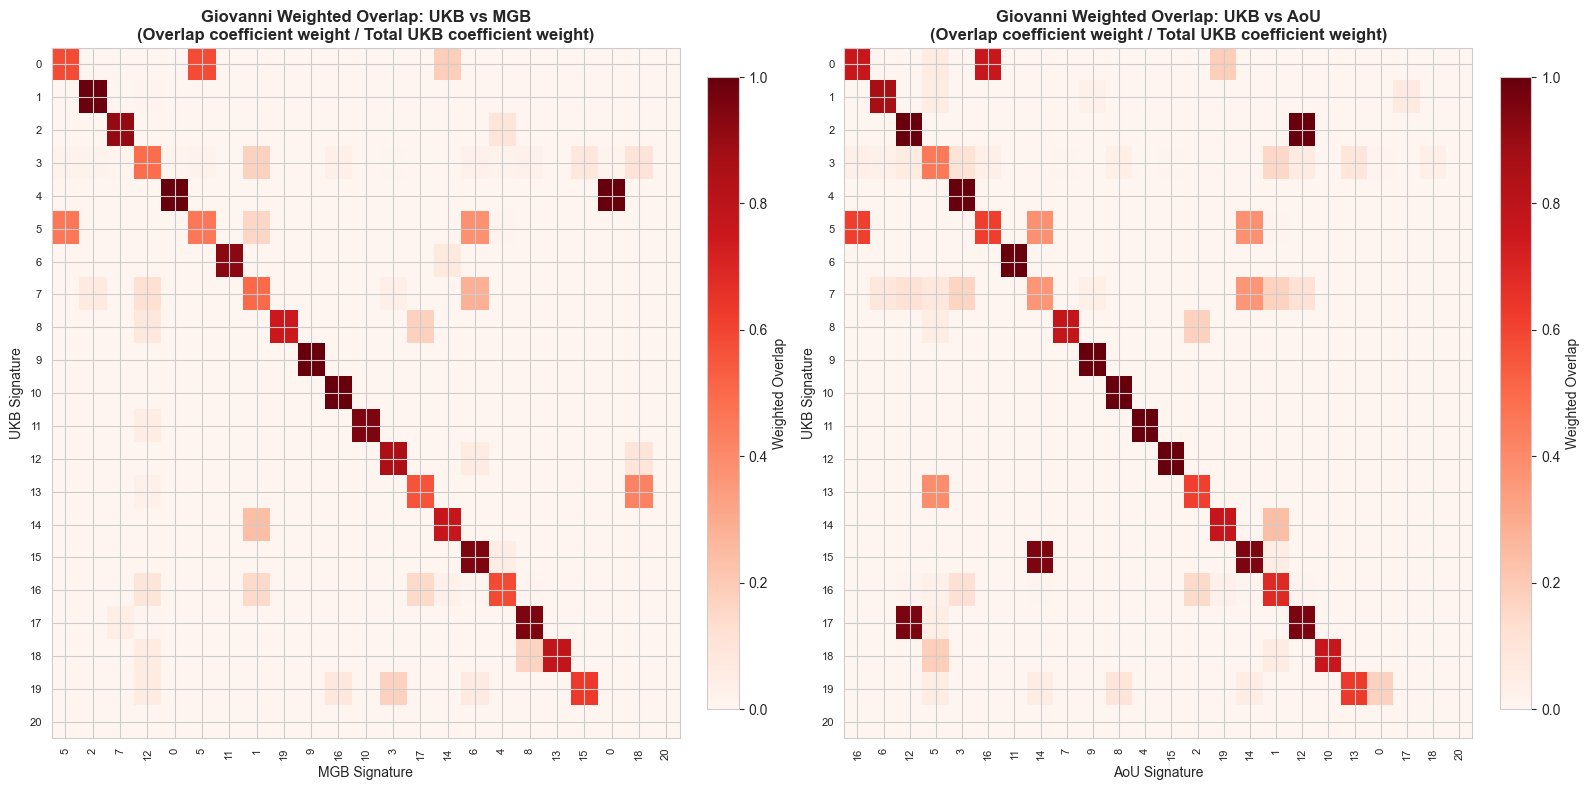


ANALYSIS COMPLETE


In [51]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/reviewer_responses/notebooks/R3/giovanni_weighted_coefficient_overlap.py

In [25]:
# Load and pool psi from batches for each cohort
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import glob

def pool_psi_from_batches(batch_dir, pattern, max_batches=None):
    """
    Load and pool psi from all batch files.
    
    Args:
        batch_dir: Directory containing batch files
        pattern: Glob pattern for batch files (e.g., "aou_model_batch_*.pt")
        max_batches: Maximum number of batches to load (None = all)
    
    Returns:
        Pooled psi (mean across batches) as numpy array, shape (K, D)
    """
    batch_dir = Path(batch_dir)
    all_psis = []
    
    # Find all matching files
    files = sorted(glob.glob(str(batch_dir / pattern)))
    print(f"  Found {len(files)} files matching pattern: {pattern}")
    
    if max_batches is not None:
        files = files[:max_batches]
    
    for file_path in files:
        try:
            checkpoint = torch.load(file_path, map_location='cpu', weights_only=False)
            
            # Extract psi
            if 'model_state_dict' in checkpoint and 'psi' in checkpoint['model_state_dict']:
                psi = checkpoint['model_state_dict']['psi']
            elif 'psi' in checkpoint:
                psi = checkpoint['psi']
            else:
                print(f"    Warning: No psi found in {Path(file_path).name}")
                continue
            
            # Convert to numpy if tensor
            if torch.is_tensor(psi):
                psi = psi.detach().cpu().numpy()
            
            all_psis.append(psi)
            print(f"    Loaded psi from {Path(file_path).name}, shape: {psi.shape}")
            
        except Exception as e:
            print(f"    Error loading {Path(file_path).name}: {e}")
            continue
    
    if len(all_psis) == 0:
        raise ValueError(f"No psi arrays loaded from {batch_dir / pattern}")
    
    # Stack and compute mean
    psi_stack = np.stack(all_psis, axis=0)  # (n_batches, K, D)
    psi_mean = np.mean(psi_stack, axis=0)  # (K, D)
    psi_std = np.std(psi_stack, axis=0)  # (K, D)
    
    print(f"  ✓ Pooled {len(all_psis)} batches")
    print(f"  ✓ Psi shape: {psi_mean.shape}")
    print(f"  ✓ Psi range: [{psi_mean.min():.4f}, {psi_mean.max():.4f}]")
    print(f"  ✓ Psi mean: {psi_mean.mean():.4f}, std (across batches): {psi_std.mean():.4f}")
    
    return psi_mean, psi_std

def load_psi_from_checkpoint(checkpoint_path):
    """Load psi from a single checkpoint file."""
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
    if 'model_state_dict' in checkpoint and 'psi' in checkpoint['model_state_dict']:
        psi = checkpoint['model_state_dict']['psi']
    elif 'psi' in checkpoint:
        psi = checkpoint['psi']
    else:
        raise ValueError(f"No psi found in {checkpoint_path}")
    
    if torch.is_tensor(psi):
        psi = psi.detach().cpu().numpy()
    
    print(f"  ✓ Loaded psi from {Path(checkpoint_path).name}, shape: {psi.shape}")
    return psi

print("="*80)
print("LOADING AND POOLING PSI FROM COHORTS")
print("="*80)

# Load UKB psi from batches
print("\n1. Loading UKB psi from batches...")
ukb_batch_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full'
ukb_pattern = 'enrollment_model_W0.0001_batch_*_*.pt'
try:
    # Load all batches (max_batches=None loads all found files)
    ukb_psi, ukb_psi_std = pool_psi_from_batches(ukb_batch_dir, ukb_pattern, max_batches=None)
    print(f"  ✓ UKB: Psi shape {ukb_psi.shape}, {ukb_psi.shape[0]} signatures, {ukb_psi.shape[1]} diseases")
except Exception as e:
    print(f"  ✗ Error loading UKB psi: {e}")
    ukb_psi = None

# Load AoU psi from batches
print("\n2. Loading AoU psi from batches...")
aou_batch_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox/aou_batches'
aou_pattern = 'aou_model_batch_*.pt'
try:
    aou_psi, aou_psi_std = pool_psi_from_batches(aou_batch_dir, aou_pattern, max_batches=None)
    print(f"  ✓ AoU: Psi shape {aou_psi.shape}, {aou_psi.shape[0]} signatures, {aou_psi.shape[1]} diseases")
except Exception as e:
    print(f"  ✗ Error loading AoU psi: {e}")
    aou_psi = None

# Load MGB psi from checkpoint
print("\n3. Loading MGB psi from checkpoint...")
mgb_psi_path = '/Users/sarahurbut/aladynoulli2/mgb_model_initialized.pt'
try:
    if Path(mgb_psi_path).exists():
        mgb_psi = load_psi_from_checkpoint(mgb_psi_path)
        print(f"  ✓ MGB: Psi shape {mgb_psi.shape}, {mgb_psi.shape[0]} signatures, {mgb_psi.shape[1]} diseases")
    else:
        print(f"  ⚠ MGB checkpoint not found at {mgb_psi_path}")
        print(f"  Trying alternative: mgb_model_with_kappa_bigam_MGB.pt")
        mgb_alt_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam_MGB.pt'
        if Path(mgb_alt_path).exists():
            mgb_psi = load_psi_from_checkpoint(mgb_alt_path)
            print(f"  ✓ MGB: Psi shape {mgb_psi.shape}, {mgb_psi.shape[0]} signatures, {mgb_psi.shape[1]} diseases")
        else:
            mgb_psi = None
except Exception as e:
    print(f"  ✗ Error loading MGB psi: {e}")
    mgb_psi = None

print("\n" + "="*80)
print("PSI LOADING COMPLETE")
print("="*80)


LOADING AND POOLING PSI FROM COHORTS

1. Loading UKB psi from batches...
  Found 40 files matching pattern: enrollment_model_W0.0001_batch_*_*.pt
    Loaded psi from enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_130000_140000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_140000_150000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_150000_160000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_160000_170000.pt, shape: (21, 348)
    Loaded psi from enrollment_model_W0.0001_batch_170000_180000.pt, shape: (21, 348)
  

In [26]:
# Define function to compute similarity matrices based on psi
# For each signature k, compare the psi vectors (across diseases) between cohorts
# Using cosine similarity: similarity = 1 - cosine_distance
# Note: Similarity will be computed AFTER disease alignment in next cell

def compute_psi_similarity_matrix(psi1, psi2, disease_mask=None, method='cosine'):
    """
    Compute similarity matrix between two psi matrices.
    
    Compares disease-signature associations (psi vectors) across cohorts.
    Each entry (k1, k2) represents how similar signature k1 in cohort 1 is to signature k2 in cohort 2,
    weighted by the strength of disease associations in both cohorts.
    
    Args:
        psi1: Psi matrix from cohort 1, shape (K1, D1) - disease associations for each signature
        psi2: Psi matrix from cohort 2, shape (K2, D2) - disease associations for each signature
        disease_mask: Boolean mask for common diseases (optional, if diseases are already aligned)
        method: 'cosine' or 'correlation'
    
    Returns:
        similarity_matrix: (K1, K2) matrix of similarities (0 to 1 scale)
    """
    K1, D1 = psi1.shape
    K2, D2 = psi2.shape
    
    # Handle disease masking if provided (should already be aligned, but just in case)
    if disease_mask is not None:
        if len(disease_mask) == D1:
            psi1_masked = psi1[:, disease_mask]
            psi2_masked = psi2[:, disease_mask]
        elif len(disease_mask) == D2:
            psi1_masked = psi1[:, disease_mask]
            psi2_masked = psi2[:, disease_mask]
        else:
            raise ValueError(f"Disease mask length {len(disease_mask)} doesn't match D1={D1} or D2={D2}")
        
        # Check if same number of diseases after masking
        if psi1_masked.shape[1] != psi2_masked.shape[1]:
            raise ValueError(f"After masking: psi1 has {psi1_masked.shape[1]} diseases, psi2 has {psi2_masked.shape[1]} diseases")
        
        psi1 = psi1_masked
        psi2 = psi2_masked
    
    similarity_matrix = np.zeros((K1, K2))
    
    for k1 in range(K1):
        vec1 = psi1[k1, :]  # Disease associations for signature k1 in cohort 1
        
        for k2 in range(K2):
            vec2 = psi2[k2, :]  # Disease associations for signature k2 in cohort 2
            
            if method == 'cosine':
                # Cosine similarity: normalized dot product (range: -1 to 1, scaled to 0 to 1)
                # Handle zero vectors
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                if norm1 == 0 or norm2 == 0:
                    similarity = 0.0
                else:
                    cosine_sim = np.dot(vec1, vec2) / (norm1 * norm2)
                    similarity = (cosine_sim + 1) / 2  # Scale from [-1, 1] to [0, 1] for interpretability
                    
            elif method == 'correlation':
                # Pearson correlation
                if np.std(vec1) == 0 or np.std(vec2) == 0:
                    similarity = 0.0
                else:
                    corr, _ = pearsonr(vec1, vec2)
                    similarity = (corr + 1) / 2  # Scale from [-1, 1] to [0, 1]
            else:
                raise ValueError(f"Unknown method: {method}")
            
            similarity_matrix[k1, k2] = similarity
    
    return similarity_matrix

print("="*80)
print("DEFINED PSI SIMILARITY FUNCTION")
print("="*80)
print("\n✓ Function ready for computing similarity matrices")
print("  Similarity will be computed AFTER disease alignment (next cell)")
print("="*80)


DEFINED PSI SIMILARITY FUNCTION

✓ Function ready for computing similarity matrices
  Similarity will be computed AFTER disease alignment (next cell)


In [27]:
# Align diseases across cohorts by name
# This ensures we're comparing the same diseases when computing similarity

def align_psi_by_disease_names(psi1, disease_names1, psi2, disease_names2):
    """
    Align two psi matrices by disease names, returning aligned psi matrices and mask.
    
    Args:
        psi1: Psi matrix from cohort 1, shape (K1, D1)
        disease_names1: List of disease names for cohort 1, length D1
        psi2: Psi matrix from cohort 2, shape (K2, D2)
        disease_names2: List of disease names for cohort 2, length D2
    
    Returns:
        psi1_aligned: Aligned psi1, shape (K1, D_common)
        psi2_aligned: Aligned psi2, shape (K2, D_common)
        common_diseases: List of common disease names
        mask1: Boolean mask for cohort 1 diseases (which are common)
        mask2: Boolean mask for cohort 2 diseases (which are common)
    """
    # Convert to lists if needed
    if isinstance(disease_names1, np.ndarray):
        disease_names1 = disease_names1.tolist()
    if isinstance(disease_names2, np.ndarray):
        disease_names2 = disease_names2.tolist()
    
    # Find common diseases
    set1 = set(disease_names1)
    set2 = set(disease_names2)
    common_diseases = sorted(list(set1 & set2))
    
    print(f"  Common diseases: {len(common_diseases)} (out of {len(disease_names1)} and {len(disease_names2)})")
    
    # Create indices for common diseases
    indices1 = [disease_names1.index(d) for d in common_diseases]
    indices2 = [disease_names2.index(d) for d in common_diseases]
    
    # Extract aligned psi matrices
    psi1_aligned = psi1[:, indices1]
    psi2_aligned = psi2[:, indices2]
    
    # Create masks
    mask1 = np.array([d in common_diseases for d in disease_names1])
    mask2 = np.array([d in common_diseases for d in disease_names2])
    
    return psi1_aligned, psi2_aligned, common_diseases, mask1, mask2

# Load disease names from checkpoints
print("="*80)
print("LOADING DISEASE NAMES AND ALIGNING PSI MATRICES")
print("="*80)

# Get disease names from UKB checkpoint
ukb_disease_names = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/disease_names.csv')['x'].tolist()
print(f"\n✓ UKB: {len(ukb_disease_names)} diseases")

# Get disease names from MGB checkpoint
mgb_checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam_MGB.pt'
if Path(mgb_checkpoint_path).exists():
    mgb_checkpoint = torch.load(mgb_checkpoint_path, map_location='cpu', weights_only=False)
    if 'disease_names' in mgb_checkpoint:
        mgb_disease_names = mgb_checkpoint['disease_names']
        if isinstance(mgb_disease_names, np.ndarray):
            mgb_disease_names = mgb_disease_names.tolist()
        elif isinstance(mgb_disease_names, pd.Series):
            mgb_disease_names = mgb_disease_names.tolist()
    else:
        mgb_disease_names = None
else:
    mgb_disease_names = None

# Get disease names from AoU checkpoint - might need to load from a batch file
aou_sample_batch = '/Users/sarahurbut/Library/CloudStorage/Dropbox/aou_batches/aou_model_batch_0_0_10000.pt'
if Path(aou_sample_batch).exists():
    aou_sample = torch.load(aou_sample_batch, map_location='cpu', weights_only=False)
    if 'disease_names' in aou_sample:
        aou_disease_names = aou_sample['disease_names']
        if isinstance(aou_disease_names, np.ndarray):
            aou_disease_names = aou_disease_names.tolist()
        elif isinstance(aou_disease_names, pd.Series):
            aou_disease_names = aou_disease_names.tolist()
    else:
        aou_disease_names = None
else:
    aou_disease_names = None

# Initialize similarity matrices
ukb_mgb_sim = None
ukb_aou_sim = None

# Align psi matrices by disease names and compute similarity
if ukb_psi is not None and mgb_psi is not None and mgb_disease_names is not None:
    print("\n1. Aligning UKB ↔ MGB by disease names...")
    try:
        ukb_psi_aligned, mgb_psi_aligned, common_ukb_mgb, _, _ = align_psi_by_disease_names(
            ukb_psi, ukb_disease_names, mgb_psi, mgb_disease_names
        )
        # Compute similarity with aligned diseases
        ukb_mgb_sim = compute_psi_similarity_matrix(ukb_psi_aligned, mgb_psi_aligned, method='cosine')
        print(f"  ✓ Aligned similarity matrix shape: {ukb_mgb_sim.shape}")
        print(f"  ✓ Similarity range: [{ukb_mgb_sim.min():.3f}, {ukb_mgb_sim.max():.3f}]")
        print(f"  ✓ Mean similarity: {ukb_mgb_sim.mean():.3f}")
    except Exception as e:
        print(f"  ✗ Error aligning/computing similarity: {e}")
        common_ukb_mgb = None
        ukb_mgb_sim = None
else:
    common_ukb_mgb = None
    if ukb_psi is None:
        print("  ⚠ Could not align UKB ↔ MGB (UKB psi not loaded)")
    elif mgb_psi is None:
        print("  ⚠ Could not align UKB ↔ MGB (MGB psi not loaded)")
    elif mgb_disease_names is None:
        print("  ⚠ Could not align UKB ↔ MGB (MGB disease names not found)")

if ukb_psi is not None and aou_psi is not None and aou_disease_names is not None:
    print("\n2. Aligning UKB ↔ AoU by disease names...")
    try:
        ukb_psi_aligned_aou, aou_psi_aligned, common_ukb_aou, _, _ = align_psi_by_disease_names(
            ukb_psi, ukb_disease_names, aou_psi, aou_disease_names
        )
        # Compute similarity with aligned diseases
        ukb_aou_sim = compute_psi_similarity_matrix(ukb_psi_aligned_aou, aou_psi_aligned, method='cosine')
        print(f"  ✓ Aligned similarity matrix shape: {ukb_aou_sim.shape}")
        print(f"  ✓ Similarity range: [{ukb_aou_sim.min():.3f}, {ukb_aou_sim.max():.3f}]")
        print(f"  ✓ Mean similarity: {ukb_aou_sim.mean():.3f}")
    except Exception as e:
        print(f"  ✗ Error aligning/computing similarity: {e}")
        common_ukb_aou = None
        ukb_aou_sim = None
else:
    common_ukb_aou = None
    if ukb_psi is None:
        print("  ⚠ Could not align UKB ↔ AoU (UKB psi not loaded)")
    elif aou_psi is None:
        print("  ⚠ Could not align UKB ↔ AoU (AoU psi not loaded)")
    elif aou_disease_names is None:
        print("  ⚠ Could not align UKB ↔ AoU (AoU disease names not found)")

print("\n" + "="*80)
print("PSI ALIGNMENT COMPLETE")
print("="*80)


LOADING DISEASE NAMES AND ALIGNING PSI MATRICES

✓ UKB: 348 diseases

1. Aligning UKB ↔ MGB by disease names...
  Common diseases: 346 (out of 348 and 346)
  ✓ Aligned similarity matrix shape: (21, 21)
  ✓ Similarity range: [0.847, 1.000]
  ✓ Mean similarity: 0.946

2. Aligning UKB ↔ AoU by disease names...
  Common diseases: 348 (out of 348 and 348)
  ✓ Aligned similarity matrix shape: (21, 21)
  ✓ Similarity range: [0.854, 1.000]
  ✓ Mean similarity: 0.953

PSI ALIGNMENT COMPLETE


In [28]:
# Find best matches and compute summary statistics
# For each UKB signature, find the best-matching signature in the other cohort
# Compute weighted similarity metrics based on psi strengths

def find_best_psi_matches(similarity_matrix, cohort1_name='UKB', cohort2_name='Other'):
    """
    Find best-matching signatures between two cohorts based on psi similarity.
    
    Args:
        similarity_matrix: (K1, K2) similarity matrix
        cohort1_name: Name of first cohort
        cohort2_name: Name of second cohort
    
    Returns:
        best_matches: DataFrame with best matches and similarity scores
        summary_stats: Dictionary with summary statistics
    """
    K1, K2 = similarity_matrix.shape
    
    best_matches = []
    for k1 in range(K1):
        best_k2 = np.argmax(similarity_matrix[k1, :])
        best_sim = similarity_matrix[k1, best_k2]
        
        best_matches.append({
            f'{cohort1_name}': k1,
            f'{cohort2_name}': int(best_k2),
            'Similarity': best_sim,
            'Mean_Similarity': similarity_matrix[k1, :].mean(),
            'Std_Similarity': similarity_matrix[k1, :].std()
        })
    
    best_matches_df = pd.DataFrame(best_matches)
    
    # Summary statistics
    summary_stats = {
        'mean_best_match': best_matches_df['Similarity'].mean(),
        'median_best_match': best_matches_df['Similarity'].median(),
        'std_best_match': best_matches_df['Similarity'].std(),
        'min_best_match': best_matches_df['Similarity'].min(),
        'max_best_match': best_matches_df['Similarity'].max(),
        'q25': best_matches_df['Similarity'].quantile(0.25),
        'q75': best_matches_df['Similarity'].quantile(0.75),
    }
    
    return best_matches_df, summary_stats

print("="*80)
print("FINDING BEST PSI-BASED MATCHES")
print("="*80)

if ukb_mgb_sim is not None:
    print("\n1. UKB ↔ MGB best matches...")
    best_matches_ukb_mgb_psi, stats_ukb_mgb = find_best_psi_matches(ukb_mgb_sim, 'UKB', 'MGB')
    print(f"  Median similarity: {stats_ukb_mgb['median_best_match']:.3f}")
    print(f"  Mean similarity: {stats_ukb_mgb['mean_best_match']:.3f}")
    print(f"  Range: [{stats_ukb_mgb['min_best_match']:.3f}, {stats_ukb_mgb['max_best_match']:.3f}]")
else:
    best_matches_ukb_mgb_psi = None
    stats_ukb_mgb = None

if ukb_aou_sim is not None:
    print("\n2. UKB ↔ AoU best matches...")
    best_matches_ukb_aou_psi, stats_ukb_aou = find_best_psi_matches(ukb_aou_sim, 'UKB', 'AoU')
    print(f"  Median similarity: {stats_ukb_aou['median_best_match']:.3f}")
    print(f"  Mean similarity: {stats_ukb_aou['mean_best_match']:.3f}")
    print(f"  Range: [{stats_ukb_aou['min_best_match']:.3f}, {stats_ukb_aou['max_best_match']:.3f}]")
else:
    best_matches_ukb_aou_psi = None
    stats_ukb_aou = None

print("\n" + "="*80)
print("BEST MATCHES IDENTIFIED")
print("="*80)


FINDING BEST PSI-BASED MATCHES

1. UKB ↔ MGB best matches...
  Median similarity: 0.989
  Mean similarity: 0.985
  Range: [0.918, 1.000]

2. UKB ↔ AoU best matches...
  Median similarity: 0.989
  Mean similarity: 0.987
  Range: [0.921, 1.000]

BEST MATCHES IDENTIFIED


CREATING PSI-BASED SIMILARITY HEATMAPS
✓ Saved psi-based similarity heatmaps to: psi_based_cross_cohort_similarity_heatmaps.pdf


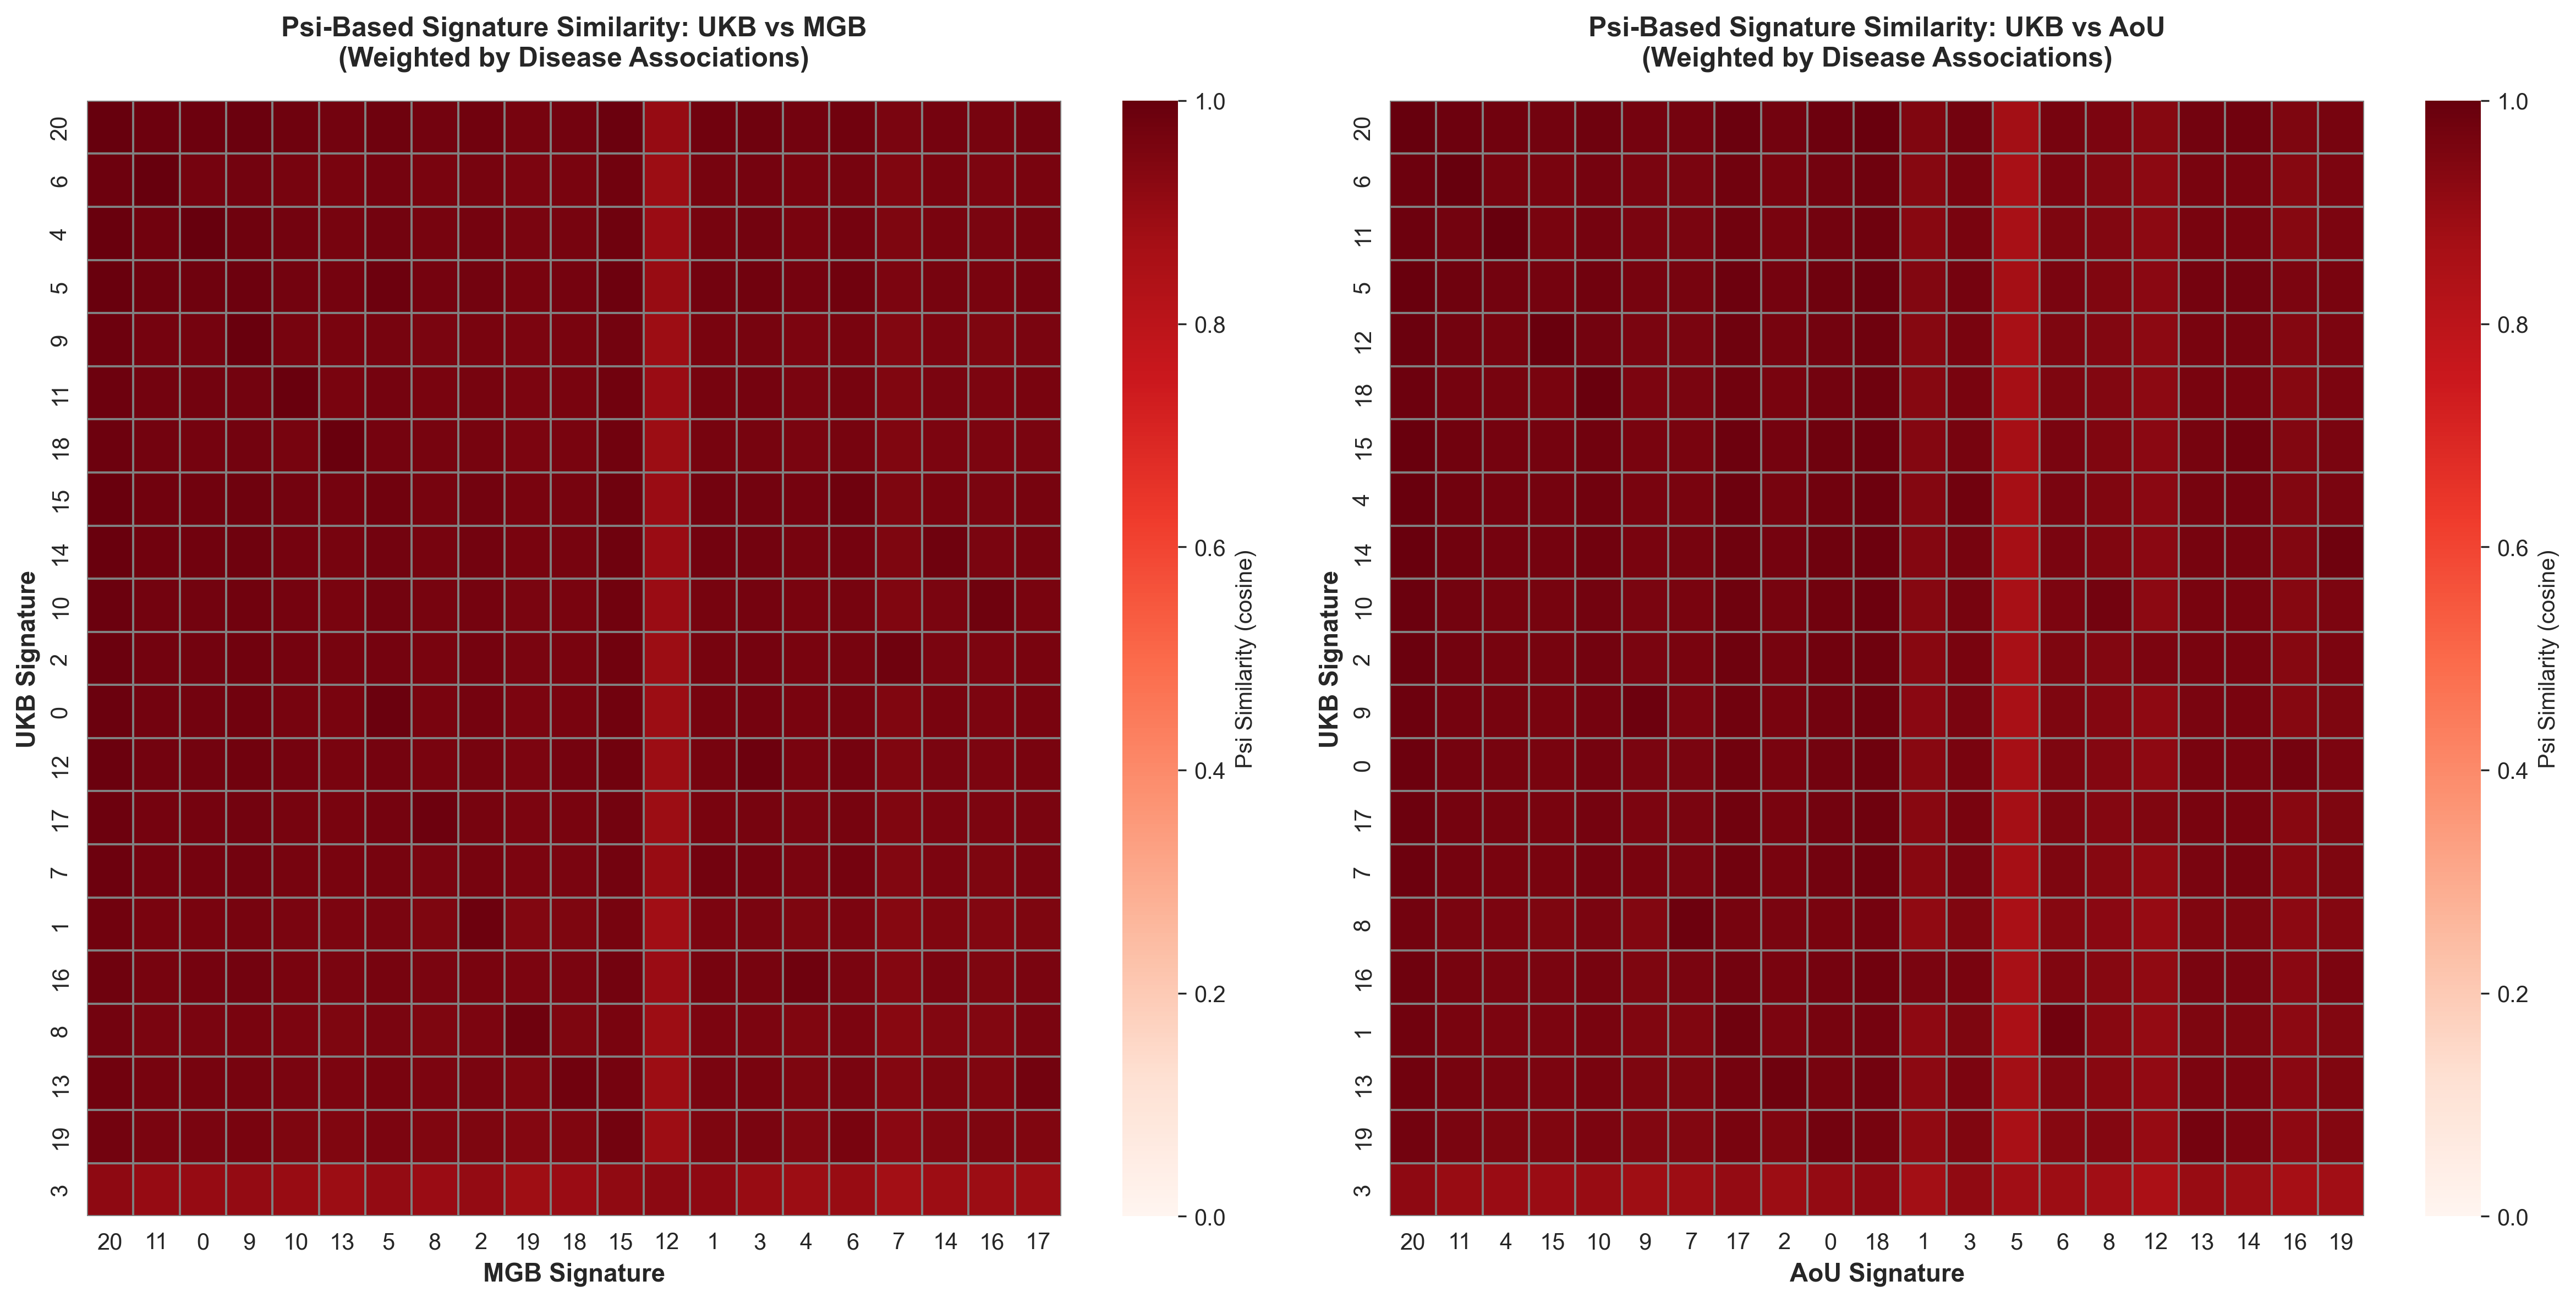

In [18]:
# Create heatmaps for psi-based similarity
# Similar style to original cluster-based heatmaps (clean, diagonal-focused)

def reorder_by_similarity_strength(sim_matrix, best_matches_df):
    """
    Reorder signatures to put high-similarity matches together.
    Sort UKB signatures by their best-match similarity (descending).
    Sort other cohort signatures to match UKB order where possible.
    """
    # Sort UKB signatures by similarity strength
    ukb_order = best_matches_df.sort_values('Similarity', ascending=False)['UKB'].values.tolist()
    
    # Find the name of the other cohort column (MGB or AoU)
    other_cohort_cols = [col for col in best_matches_df.columns if col not in ['UKB', 'Similarity', 'Mean_Similarity', 'Std_Similarity']]
    if len(other_cohort_cols) == 0:
        # Fallback: assume it's the second column
        other_cohort_col = [col for col in best_matches_df.columns if col != 'UKB'][0]
    else:
        other_cohort_col = other_cohort_cols[0]
    
    # For the other cohort, order by which ones match to high-similarity UKB sigs first
    other_order = []
    seen = set()
    
    # First add signatures that match to high-similarity UKB signatures
    for ukb_sig in ukb_order:
        match_row = best_matches_df[best_matches_df['UKB'] == ukb_sig]
        if len(match_row) > 0:
            other_sig = match_row.iloc[0][other_cohort_col]
            if other_sig not in seen:
                other_order.append(other_sig)
                seen.add(other_sig)
    
    # Add any remaining signatures
    all_other = list(range(sim_matrix.shape[1]))
    for sig in all_other:
        if sig not in seen:
            other_order.append(sig)
    
    return ukb_order, other_order

print("="*80)
print("CREATING PSI-BASED SIMILARITY HEATMAPS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

if ukb_mgb_sim is not None and best_matches_ukb_mgb_psi is not None:
    # Reorder for better visualization
    ukb_order, mgb_order = reorder_by_similarity_strength(ukb_mgb_sim, best_matches_ukb_mgb_psi)
    
    # Convert to integer arrays for indexing
    ukb_order = np.array(ukb_order, dtype=int)
    mgb_order = np.array(mgb_order, dtype=int)
    
    # Create ordered similarity matrix (use numpy fancy indexing)
    ukb_mgb_sim_array = np.array(ukb_mgb_sim) if not isinstance(ukb_mgb_sim, np.ndarray) else ukb_mgb_sim
    ukb_mgb_sim_ordered = ukb_mgb_sim_array[np.ix_(ukb_order, mgb_order)]
    
    # Convert to DataFrame for seaborn heatmap (like original)
    ukb_mgb_sim_df = pd.DataFrame(
        ukb_mgb_sim_ordered,
        index=[k for k in ukb_order],
        columns=[k for k in mgb_order]
    )
    
    # Create heatmap using seaborn (like original cluster-based heatmaps)
    sns.heatmap(
        ukb_mgb_sim_df,
        cmap='Reds',
        vmin=0, vmax=1,
        ax=axes[0],
        cbar_kws={'label': 'Psi Similarity (cosine)'},
        linewidths=0.5,
        linecolor='gray',
        annot=False,
        fmt='.2f'
    )
    
    axes[0].set_title('Psi-Based Signature Similarity: UKB vs MGB\n(Weighted by Disease Associations)', 
                      fontsize=12, fontweight='bold', pad=15)
    axes[0].set_xlabel('MGB Signature', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('UKB Signature', fontsize=11, fontweight='bold')
    
else:
    axes[0].text(0.5, 0.5, 'UKB ↔ MGB\nSimilarity unavailable', 
                 ha='center', va='center', fontsize=12)
    axes[0].set_title('UKB vs MGB', fontsize=12, fontweight='bold')

if ukb_aou_sim is not None and best_matches_ukb_aou_psi is not None:
    # Reorder for better visualization
    ukb_order_aou, aou_order = reorder_by_similarity_strength(ukb_aou_sim, best_matches_ukb_aou_psi)
    
    # Convert to integer arrays for indexing
    ukb_order_aou = np.array(ukb_order_aou, dtype=int)
    aou_order = np.array(aou_order, dtype=int)
    
    # Create ordered similarity matrix (use numpy fancy indexing)
    ukb_aou_sim_array = np.array(ukb_aou_sim) if not isinstance(ukb_aou_sim, np.ndarray) else ukb_aou_sim
    ukb_aou_sim_ordered = ukb_aou_sim_array[np.ix_(ukb_order_aou, aou_order)]
    
    # Convert to DataFrame for seaborn heatmap (like original)
    ukb_aou_sim_df = pd.DataFrame(
        ukb_aou_sim_ordered,
        index=[k for k in ukb_order_aou],
        columns=[k for k in aou_order]
    )
    
    # Create heatmap using seaborn (like original cluster-based heatmaps)
    sns.heatmap(
        ukb_aou_sim_df,
        cmap='Reds',
        vmin=0, vmax=1,
        ax=axes[1],
        cbar_kws={'label': 'Psi Similarity (cosine)'},
        linewidths=0.5,
        linecolor='gray',
        annot=False,
        fmt='.2f'
    )
    
    axes[1].set_title('Psi-Based Signature Similarity: UKB vs AoU\n(Weighted by Disease Associations)', 
                      fontsize=12, fontweight='bold', pad=15)
    axes[1].set_xlabel('AoU Signature', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('UKB Signature', fontsize=11, fontweight='bold')
    
else:
    axes[1].text(0.5, 0.5, 'UKB ↔ AoU\nSimilarity unavailable', 
                 ha='center', va='center', fontsize=12)
    axes[1].set_title('UKB vs AoU', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'psi_based_cross_cohort_similarity_heatmaps.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'psi_based_cross_cohort_similarity_heatmaps.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved psi-based similarity heatmaps to: {OUTPUT_DIR / 'psi_based_cross_cohort_similarity_heatmaps.pdf'}")
plt.show()


In [29]:
# Compare psi-based similarity with cluster-based similarity
# This shows how using posterior psi (weighted by fit) differs from initial cluster assignments

# Check if cluster-based matches exist (from original analysis in earlier cells)
# Use try-except to safely check for variables that may not exist if earlier cells weren't run
try:
    has_cluster_mgb = best_matches_mgb is not None
except NameError:
    has_cluster_mgb = False
    print("⚠ Note: Cluster-based matches (best_matches_mgb) not found. Run cells 8-10 first for comparison.")

try:
    has_cluster_aou = best_matches_aou is not None
except NameError:
    has_cluster_aou = False
    print("⚠ Note: Cluster-based matches (best_matches_aou) not found. Run cells 8-10 first for comparison.")

if best_matches_ukb_mgb_psi is not None and has_cluster_mgb:
    print("="*80)
    print("COMPARISON: PSI-BASED vs CLUSTER-BASED MATCHES (UKB ↔ MGB)")
    print("="*80)
    
    # Merge best matches
    comparison_mgb = pd.merge(
        best_matches_ukb_mgb_psi[['UKB', 'MGB', 'Similarity']].rename(columns={'MGB': 'MGB_psi', 'Similarity': 'Psi_Similarity'}),
        best_matches_mgb[['UKB', 'MGB', 'Proportion']].rename(columns={'MGB': 'MGB_cluster', 'Proportion': 'Cluster_Proportion'}),
        on='UKB',
        how='inner'
    )
    
    # Count matches where psi and cluster agree
    matches_agree = (comparison_mgb['MGB_psi'] == comparison_mgb['MGB_cluster']).sum()
    matches_total = len(comparison_mgb)
    agreement_rate = matches_agree / matches_total if matches_total > 0 else 0
    
    print(f"\nAgreement between psi-based and cluster-based matches: {matches_agree}/{matches_total} ({agreement_rate*100:.1f}%)")
    print(f"\nMean psi similarity: {comparison_mgb['Psi_Similarity'].mean():.3f}")
    print(f"Mean cluster proportion: {comparison_mgb['Cluster_Proportion'].mean():.3f}")
    
    # Show cases where they differ
    differing = comparison_mgb[comparison_mgb['MGB_psi'] != comparison_mgb['MGB_cluster']]
    if len(differing) > 0:
        print(f"\nSignatures where psi and cluster matches differ ({len(differing)} cases):")
        print(differing[['UKB', 'MGB_psi', 'MGB_cluster', 'Psi_Similarity', 'Cluster_Proportion']].to_string(index=False))
else:
    if best_matches_ukb_mgb_psi is not None:
        print("\n⚠ Cannot compare UKB ↔ MGB: Cluster-based matches not available (run cells 8-10 first)")

if best_matches_ukb_aou_psi is not None and has_cluster_aou:
    print("\n" + "="*80)
    print("COMPARISON: PSI-BASED vs CLUSTER-BASED MATCHES (UKB ↔ AoU)")
    print("="*80)
    
    comparison_aou = pd.merge(
        best_matches_ukb_aou_psi[['UKB', 'AoU', 'Similarity']].rename(columns={'AoU': 'AoU_psi', 'Similarity': 'Psi_Similarity'}),
        best_matches_aou[['UKB', 'AoU', 'Proportion']].rename(columns={'AoU': 'AoU_cluster', 'Proportion': 'Cluster_Proportion'}),
        on='UKB',
        how='inner'
    )
    
    matches_agree = (comparison_aou['AoU_psi'] == comparison_aou['AoU_cluster']).sum()
    matches_total = len(comparison_aou)
    agreement_rate = matches_agree / matches_total if matches_total > 0 else 0
    
    print(f"\nAgreement between psi-based and cluster-based matches: {matches_agree}/{matches_total} ({agreement_rate*100:.1f}%)")
    print(f"\nMean psi similarity: {comparison_aou['Psi_Similarity'].mean():.3f}")
    print(f"Mean cluster proportion: {comparison_aou['Cluster_Proportion'].mean():.3f}")
    
    differing = comparison_aou[comparison_aou['AoU_psi'] != comparison_aou['AoU_cluster']]
    if len(differing) > 0:
        print(f"\nSignatures where psi and cluster matches differ ({len(differing)} cases):")
        print(differing[['UKB', 'AoU_psi', 'AoU_cluster', 'Psi_Similarity', 'Cluster_Proportion']].to_string(index=False))
else:
    if best_matches_ukb_aou_psi is not None:
        print("\n⚠ Cannot compare UKB ↔ AoU: Cluster-based matches not available (run cells 8-10 first)")


COMPARISON: PSI-BASED vs CLUSTER-BASED MATCHES (UKB ↔ MGB)

Agreement between psi-based and cluster-based matches: 7/20 (35.0%)

Mean psi similarity: 0.985
Mean cluster proportion: 0.782

Signatures where psi and cluster matches differ (13 cases):
 UKB  MGB_psi  MGB_cluster  Psi_Similarity  Cluster_Proportion
   0       20            5        0.988227            0.928571
   2       20            7        0.988902            0.933333
   3       20           12        0.918245            0.560976
   5       20            5        0.995764            0.571429
   7       20            1        0.986080            0.500000
  10       20           16        0.989447            1.000000
  12       20            3        0.988498            0.714286
  13       20           18        0.979726            0.615385
  14       20           14        0.992778            0.900000
  15       20            6        0.992997            0.800000
  16       20            4        0.983608            0.689

In [30]:
def calculate_weighted_modified_jaccard(ukb_psi, other_psi, ukb_clusters, other_clusters, 
                                       ukb_disease_names, other_disease_names, 
                                       common_diseases, biobank_name):
    """
    Calculate weighted modified Jaccard similarity using cluster assignments weighted by psi coefficients.
    
    For each UKB cluster k:
    1. Get set of diseases in UKB cluster k (from common diseases)
    2. For each cluster in other biobank, calculate weighted intersection
    3. Weight by psi coefficients: stronger associations contribute more
    4. Find best-matching cluster (maximum weighted intersection / weighted UKB cluster size)
    
    Returns:
    --------
    weighted_jaccard_scores : list
        List of weighted Jaccard scores for each UKB cluster
    cluster_details : dict
        Dictionary with details for each cluster
    """
    # Create disease name to index mapping
    ukb_disease_to_idx = {d: i for i, d in enumerate(ukb_disease_names)}
    other_disease_to_idx = {d: i for i, d in enumerate(other_disease_names)}
    
    # Create mapping: common disease name -> (ukb_idx, other_idx)
    disease_mapping = {}
    for d in common_diseases:
        if d in ukb_disease_to_idx and d in other_disease_to_idx:
            disease_mapping[d] = (ukb_disease_to_idx[d], other_disease_to_idx[d])
    
    weighted_jaccard_scores = []
    cluster_details = {}
    
    # Get unique UKB clusters
    ukb_unique_clusters = sorted(set(ukb_clusters))
    
    for ukb_sig in ukb_unique_clusters:
        # Get diseases in UKB signature (only common diseases)
        ukb_sig_diseases = []
        for d, (ukb_idx, other_idx) in disease_mapping.items():
            if ukb_clusters[ukb_idx] == ukb_sig:
                ukb_sig_diseases.append((d, ukb_idx, other_idx))
        
        if len(ukb_sig_diseases) == 0:
            continue
        
        # Calculate weighted size of UKB signature (sum of psi values)
        ukb_weighted_size = sum(ukb_psi[ukb_sig, ukb_idx] for d, ukb_idx, other_idx in ukb_sig_diseases)
        
        if ukb_weighted_size == 0:
            continue
        
        # Find best matching cluster in other biobank
        best_match_score = 0
        best_match_cluster = None
        best_weighted_overlap = 0
        
        # Get unique clusters in other biobank
        other_unique_clusters = sorted(set(other_clusters))
        
        for other_sig in other_unique_clusters:
            # Calculate weighted overlap: sum of psi values for diseases in both signatures
            weighted_overlap = 0
            weighted_ukb_only = ukb_weighted_size  # Start with UKB signature weighted size
            
            for d, ukb_idx, other_idx in ukb_sig_diseases:
                if other_clusters[other_idx] == other_sig:
                    # Disease is in overlap: add both psi values
                    weighted_overlap += (ukb_psi[ukb_sig, ukb_idx] + other_psi[other_sig, other_idx])
                    weighted_ukb_only -= ukb_psi[ukb_sig, ukb_idx]  # Remove from UKB-only count
            
            # Add diseases only in other signature
            weighted_other_only = 0
            for d, (ukb_idx, other_idx) in disease_mapping.items():
                if other_clusters[other_idx] == other_sig and ukb_clusters[ukb_idx] != ukb_sig:
                    weighted_other_only += other_psi[other_sig, other_idx]
            
            # Weighted union = weighted_overlap + weighted_ukb_only + weighted_other_only
            weighted_union = weighted_overlap + weighted_ukb_only + weighted_other_only
            
            # Weighted Jaccard: weighted_overlap / weighted_union
            if weighted_union > 0:
                weighted_jaccard = weighted_overlap / weighted_union
            else:
                weighted_jaccard = 0.0
            
            # Use intersection over UKB size (like original modified Jaccard)
            # Weighted overlap divided by 2*ukb_weighted_size (since overlap has both psi values)
            weighted_jaccard_over_ukb = weighted_overlap / (2 * ukb_weighted_size) if ukb_weighted_size > 0 else 0.0
            
            # Use the intersection/UKB version to match original modified Jaccard logic
            if weighted_jaccard_over_ukb > best_match_score:
                best_match_score = weighted_jaccard_over_ukb
                best_match_cluster = other_sig
                best_weighted_overlap = weighted_overlap
        
        weighted_jaccard_scores.append(best_match_score)
        cluster_details[ukb_sig] = {
            'weighted_jaccard': best_match_score,
            'best_match': best_match_cluster,
            'weighted_overlap': best_weighted_overlap,
            'ukb_weighted_size': ukb_weighted_size
        }
    
    return weighted_jaccard_scores, cluster_details


# Load clusters (you'll need to add this to your existing code)
print("\n" + "="*80)
print("LOADING CLUSTERS FOR WEIGHTED JACCARD")
print("="*80)

# Load UKB clusters and disease names
ukb_checkpoint_ref = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam.pt', map_location='cpu')
ukb_clusters = ukb_checkpoint_ref['clusters']
ukb_disease_names = ukb_checkpoint_ref['disease_names']
if isinstance(ukb_clusters, torch.Tensor):
    ukb_clusters = ukb_clusters.numpy()
if isinstance(ukb_disease_names, (list, tuple)):
    ukb_disease_names = list(ukb_disease_names)
elif hasattr(ukb_disease_names, 'values'):
    ukb_disease_names = ukb_disease_names.values.tolist()

# Load MGB clusters and disease names
mgb_checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam_MGB.pt', map_location='cpu')
mgb_clusters = mgb_checkpoint['clusters']
mgb_disease_names = mgb_checkpoint['disease_names']
if isinstance(mgb_clusters, torch.Tensor):
    mgb_clusters = mgb_clusters.numpy()
if isinstance(mgb_disease_names, (list, tuple)):
    mgb_disease_names = list(mgb_disease_names)
elif hasattr(mgb_disease_names, 'values'):
    mgb_disease_names = mgb_disease_names.values.tolist()

# Load AoU clusters and disease names  
aou_checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam_AOU.pt', map_location='cpu')
aou_clusters = aou_checkpoint['clusters']
aou_disease_names = aou_checkpoint['disease_names']
if isinstance(aou_clusters, torch.Tensor):
    aou_clusters = aou_clusters.numpy()
if isinstance(aou_disease_names, (list, tuple)):
    aou_disease_names = list(aou_disease_names)
elif hasattr(aou_disease_names, 'values'):
    aou_disease_names = aou_disease_names.values.tolist()

# Find common diseases
common_ukb_mgb = list(set(ukb_disease_names) & set(mgb_disease_names))
common_ukb_aou = list(set(ukb_disease_names) & set(aou_disease_names))

print(f"\nUKB: {len(ukb_disease_names)} diseases, {ukb_clusters.max()+1} signatures")
print(f"MGB: {len(mgb_disease_names)} diseases, {mgb_clusters.max()+1} signatures")
print(f"AoU: {len(aou_disease_names)} diseases, {aou_clusters.max()+1} signatures")
print(f"\nCommon diseases (UKB ↔ MGB): {len(common_ukb_mgb)}")
print(f"Common diseases (UKB ↔ AoU): {len(common_ukb_aou)}")

# Calculate weighted Jaccard
print("\n" + "="*80)
print("CALCULATING WEIGHTED MODIFIED JACCARD")
print("="*80)

print("\nUKB ↔ MGB:")
weighted_jaccard_mgb, weighted_details_mgb = calculate_weighted_modified_jaccard(
    ukb_psi, mgb_psi, ukb_clusters, mgb_clusters,
    ukb_disease_names, mgb_disease_names, common_ukb_mgb, 'MGB'
)

print("\nUKB ↔ AoU:")
weighted_jaccard_aou, weighted_details_aou = calculate_weighted_modified_jaccard(
    ukb_psi, aou_psi, ukb_clusters, aou_clusters,
    ukb_disease_names, aou_disease_names, common_ukb_aou, 'AoU'
)

# Compare with binary Jaccard
print("\n" + "="*80)
print("COMPARING WEIGHTED vs BINARY JACCARD")
print("="*80)
print(f"\nWeighted Jaccard (UKB ↔ MGB): median = {np.median(weighted_jaccard_mgb):.3f}")
print(f"Weighted Jaccard (UKB ↔ AoU): median = {np.median(weighted_jaccard_aou):.3f}")


LOADING CLUSTERS FOR WEIGHTED JACCARD

UKB: 348 diseases, 20 signatures
MGB: 346 diseases, 20 signatures
AoU: 348 diseases, 20 signatures

Common diseases (UKB ↔ MGB): 346
Common diseases (UKB ↔ AoU): 348

CALCULATING WEIGHTED MODIFIED JACCARD

UKB ↔ MGB:

UKB ↔ AoU:

COMPARING WEIGHTED vs BINARY JACCARD

Weighted Jaccard (UKB ↔ MGB): median = 1.295
Weighted Jaccard (UKB ↔ AoU): median = 0.954


In [31]:
# Compare weighted vs binary matches
print("\n" + "="*80)
print("COMPARING WEIGHTED vs BINARY MATCHES")
print("="*80)

# Load binary matches (you'll need to have details_mgb and details_aou from earlier)
# If you don't have them loaded, you'll need to re-run the binary calculation
# For now, let's assume they exist or create a comparison structure

# Create comparison DataFrames
def create_match_comparison(weighted_details, binary_details, cohort_name):
    """Create DataFrame comparing weighted and binary matches."""
    comparison_data = []
    
    # Get all UKB signatures that appear in both
    all_sigs = sorted(set(list(weighted_details.keys()) + list(binary_details.keys())))
    
    for ukb_sig in all_sigs:
        weighted_match = weighted_details.get(ukb_sig, {}).get('best_match', None)
        weighted_score = weighted_details.get(ukb_sig, {}).get('weighted_jaccard', 0)
        binary_match = binary_details.get(ukb_sig, {}).get('best_match', None)
        binary_score = binary_details.get(ukb_sig, {}).get('jaccard', 0)
        
        match_agreement = "✓" if weighted_match == binary_match else "✗"
        
        comparison_data.append({
            'UKB_Sig': ukb_sig,
            f'{cohort_name}_Binary': binary_match,
            f'{cohort_name}_Weighted': weighted_match,
            'Agreement': match_agreement,
            'Binary_Score': binary_score,
            'Weighted_Score': weighted_score,
            'Score_Diff': weighted_score - binary_score
        })
    
    return pd.DataFrame(comparison_data)

# Assuming you have details_mgb and details_aou from the binary calculation
# If not, you'll need to load/calculate them first

print("\nUKB ↔ MGB Match Comparison:")
comparison_mgb = create_match_comparison(weighted_details_mgb, details_mgb, 'MGB')
print(comparison_mgb.to_string(index=False))

print(f"\nAgreement: {comparison_mgb['Agreement'].value_counts().to_dict()}")

print("\n" + "-"*80)
print("UKB ↔ AoU Match Comparison:")
comparison_aou = create_match_comparison(weighted_details_aou, details_aou, 'AoU')
print(comparison_aou.to_string(index=False))

print(f"\nAgreement: {comparison_aou['Agreement'].value_counts().to_dict()}")

# Show signatures where matches differ
print("\n" + "="*80)
print("SIGNATURES WHERE MATCHES DIFFER")
print("="*80)

differing_mgb = comparison_mgb[comparison_mgb['Agreement'] == '✗']
if len(differing_mgb) > 0:
    print(f"\nUKB ↔ MGB: {len(differing_mgb)} signatures with different matches:")
    print(differing_mgb[['UKB_Sig', 'MGB_Binary', 'MGB_Weighted', 'Binary_Score', 'Weighted_Score']].to_string(index=False))
else:
    print("\nUKB ↔ MGB: All matches agree! ✓")

differing_aou = comparison_aou[comparison_aou['Agreement'] == '✗']
if len(differing_aou) > 0:
    print(f"\nUKB ↔ AoU: {len(differing_aou)} signatures with different matches:")
    print(differing_aou[['UKB_Sig', 'AoU_Binary', 'AoU_Weighted', 'Binary_Score', 'Weighted_Score']].to_string(index=False))
else:
    print("\nUKB ↔ AoU: All matches agree! ✓")

# Check if any weighted matches go to signature 20 (healthy signature)
print("\n" + "="*80)
print("CHECKING FOR SIGNATURE 20 (HEALTHY) MATCHES")
print("="*80)

mgb_to_healthy = comparison_mgb[comparison_mgb['MGB_Weighted'] == 20]
aou_to_healthy = comparison_aou[comparison_aou['AoU_Weighted'] == 20]

print(f"\nUKB ↔ MGB: {len(mgb_to_healthy)} signatures matched to MGB Signature 20 (healthy)")
if len(mgb_to_healthy) > 0:
    print(mgb_to_healthy[['UKB_Sig', 'MGB_Binary', 'MGB_Weighted']].to_string(index=False))

print(f"\nUKB ↔ AoU: {len(aou_to_healthy)} signatures matched to AoU Signature 20 (healthy)")
if len(aou_to_healthy) > 0:
    print(aou_to_healthy[['UKB_Sig', 'AoU_Binary', 'AoU_Weighted']].to_string(index=False))

# Show example diseases from a few matched signatures to verify biological coherence
print("\n" + "="*80)
print("EXAMPLE DISEASES FROM MATCHED SIGNATURES (to verify biological coherence)")
print("="*80)

def show_top_diseases_in_signature(psi, clusters, disease_names, sig_idx, top_n=5):
    """Show top N diseases in a signature based on psi values."""
    sig_disease_indices = np.where(clusters == sig_idx)[0]
    if len(sig_disease_indices) == 0:
        return []
    
    # Get psi values for diseases in this signature
    psi_values = [(i, psi[sig_idx, i]) for i in sig_disease_indices]
    # Sort by psi (descending)
    psi_values.sort(key=lambda x: x[1], reverse=True)
    
    # Get top N
    top_indices = [i for i, _ in psi_values[:top_n]]
    top_diseases = [disease_names[i] for i in top_indices if i < len(disease_names)]
    return top_diseases

# Show a few examples
example_sigs = [5, 6, 11]  # Cardiovascular, Cancer, Cerebrovascular

for ukb_sig in example_sigs:
    if ukb_sig in weighted_details_mgb:
        mgb_match = weighted_details_mgb[ukb_sig]['best_match']
        print(f"\nUKB Signature {ukb_sig} → MGB Signature {mgb_match}:")
        
        ukb_top = show_top_diseases_in_signature(ukb_psi, ukb_clusters, ukb_disease_names, ukb_sig, top_n=5)
        mgb_top = show_top_diseases_in_signature(mgb_psi, mgb_clusters, mgb_disease_names, mgb_match, top_n=5)
        
        print(f"  UKB top diseases: {', '.join(ukb_top[:3])}")
        print(f"  MGB top diseases: {', '.join(mgb_top[:3])}")

for ukb_sig in example_sigs:
    if ukb_sig in weighted_details_aou:
        aou_match = weighted_details_aou[ukb_sig]['best_match']
        print(f"\nUKB Signature {ukb_sig} → AoU Signature {aou_match}:")
        
        ukb_top = show_top_diseases_in_signature(ukb_psi, ukb_clusters, ukb_disease_names, ukb_sig, top_n=5)
        aou_top = show_top_diseases_in_signature(aou_psi, aou_clusters, aou_disease_names, aou_match, top_n=5)
        
        print(f"  UKB top diseases: {', '.join(ukb_top[:3])}")
        print(f"  AoU top diseases: {', '.join(aou_top[:3])}")


COMPARING WEIGHTED vs BINARY MATCHES

UKB ↔ MGB Match Comparison:
 UKB_Sig  MGB_Binary  MGB_Weighted Agreement  Binary_Score  Weighted_Score  Score_Diff
       0           5           5.0         ✓      0.928571       38.935484   38.006912
       1           2           2.0         ✓      0.952381        2.204099    1.251718
       2           7           NaN         ✗      0.933333        0.000000   -0.933333
       3          12          12.0         ✓      0.560976        1.917849    1.356873
       4           0           0.0         ✓      1.000000        1.683012    0.683012
       5           5           NaN         ✗      0.571429        0.000000   -0.571429
       6          11          11.0         ✓      0.875000        1.130759    0.255759
       7           1           NaN         ✗      0.500000        0.000000   -0.500000
       8          19          19.0         ✓      0.678571        1.617055    0.938483
       9           9           9.0         ✓      1.000000     

In [33]:
# Re-run weighted Jaccard with corrected MGB model
print("\n" + "="*80)
print("RE-RUNNING WEIGHTED JACCARD WITH CORRECTED MGB MODEL")
print("="*80)

# Make sure we're using the correct MGB psi
print("\nVerifying MGB psi source:")
mgb_checkpoint_verify = torch.load('/Users/sarahurbut/aladynoulli2/mgb_model_initialized.pt', map_location='cpu')
if 'model_state_dict' in mgb_checkpoint_verify and 'psi' in mgb_checkpoint_verify['model_state_dict']:
    mgb_psi_verify = mgb_checkpoint_verify['model_state_dict']['psi']
    if torch.is_tensor(mgb_psi_verify):
        mgb_psi_verify = mgb_psi_verify.detach().cpu().numpy()
    print(f"  MGB psi range: [{mgb_psi_verify.min():.3f}, {mgb_psi_verify.max():.3f}]")
    print(f"  MGB psi mean: {mgb_psi_verify.mean():.3f}")
    print(f"  ✓ Using mgb_model_initialized.pt (trained with corrected E/prevalence)")

# Re-calculate weighted Jaccard
print("\nUKB ↔ MGB:")
weighted_jaccard_mgb_new, weighted_details_mgb_new = calculate_weighted_modified_jaccard(
    ukb_psi, mgb_psi, ukb_clusters, mgb_clusters,
    ukb_disease_names, mgb_disease_names, common_ukb_mgb, 'MGB'
)

print("\nUKB ↔ AoU:")
weighted_jaccard_aou_new, weighted_details_aou_new = calculate_weighted_modified_jaccard(
    ukb_psi, aou_psi, ukb_clusters, aou_clusters,
    ukb_disease_names, aou_disease_names, common_ukb_aou, 'AoU'
)

# Compare results
print("\n" + "="*80)
print("WEIGHTED JACCARD RESULTS (with corrected MGB)")
print("="*80)
print(f"\nWeighted Jaccard (UKB ↔ MGB): median = {np.median(weighted_jaccard_mgb_new):.3f}")
print(f"  Range: [{np.min(weighted_jaccard_mgb_new):.3f}, {np.max(weighted_jaccard_mgb_new):.3f}]")
print(f"  IQR: [{np.percentile(weighted_jaccard_mgb_new, 25):.3f}, {np.percentile(weighted_jaccard_mgb_new, 75):.3f}]")

print(f"\nWeighted Jaccard (UKB ↔ AoU): median = {np.median(weighted_jaccard_aou_new):.3f}")
print(f"  Range: [{np.min(weighted_jaccard_aou_new):.3f}, {np.max(weighted_jaccard_aou_new):.3f}]")
print(f"  IQR: [{np.percentile(weighted_jaccard_aou_new, 25):.3f}, {np.percentile(weighted_jaccard_aou_new, 75):.3f}]")

# Compare with binary
print(f"\nBinary Jaccard (UKB ↔ MGB): median = {np.median(jaccard_mgb):.3f}")
print(f"Binary Jaccard (UKB ↔ AoU): median = {np.median(jaccard_aou):.3f}")

# Check how many are > 1.0 (indicating the formula bug)
mgb_over_one = np.sum(np.array(weighted_jaccard_mgb_new) > 1.0)
aou_over_one = np.sum(np.array(weighted_jaccard_aou_new) > 1.0)
print(f"\n⚠ Weighted scores > 1.0 (formula issue):")
print(f"  UKB ↔ MGB: {mgb_over_one}/{len(weighted_jaccard_mgb_new)} signatures")
print(f"  UKB ↔ AoU: {aou_over_one}/{len(weighted_jaccard_aou_new)} signatures")


RE-RUNNING WEIGHTED JACCARD WITH CORRECTED MGB MODEL

Verifying MGB psi source:
  MGB psi range: [-5.188, 3.483]
  MGB psi mean: -2.039
  ✓ Using mgb_model_initialized.pt (trained with corrected E/prevalence)

UKB ↔ MGB:

UKB ↔ AoU:

WEIGHTED JACCARD RESULTS (with corrected MGB)

Weighted Jaccard (UKB ↔ MGB): median = 1.295
  Range: [0.000, 38.935]
  IQR: [0.000, 1.925]

Weighted Jaccard (UKB ↔ AoU): median = 0.954
  Range: [0.000, 10.132]
  IQR: [0.000, 1.378]

Binary Jaccard (UKB ↔ MGB): median = 0.838
Binary Jaccard (UKB ↔ AoU): median = 0.782

⚠ Weighted scores > 1.0 (formula issue):
  UKB ↔ MGB: 12/20 signatures
  UKB ↔ AoU: 9/20 signatures


In [24]:
# Inspect diseases in signatures with different matches
print("\n" + "="*80)
print("DISEASES IN SIGNATURES WITH DIFFERENT MATCHES")
print("="*80)

def get_diseases_in_signature(clusters, disease_names, sig_idx, top_n=10):
    """Get diseases in a signature, sorted by cluster assignment."""
    sig_disease_indices = np.where(clusters == sig_idx)[0]
    diseases = [disease_names[i] for i in sig_disease_indices if i < len(disease_names)]
    return diseases[:top_n]

def get_diseases_with_psi(psi, clusters, disease_names, sig_idx, top_n=10):
    """Get top diseases in a signature based on psi values."""
    sig_disease_indices = np.where(clusters == sig_idx)[0]
    if len(sig_disease_indices) == 0:
        return []
    
    # Get psi values and sort
    psi_values = [(i, psi[sig_idx, i]) for i in sig_disease_indices]
    psi_values.sort(key=lambda x: x[1], reverse=True)
    
    # Get top N
    top_indices = [i for i, _ in psi_values[:top_n]]
    top_diseases = [(disease_names[i], psi[sig_idx, i]) for i in top_indices if i < len(disease_names)]
    return top_diseases

# Check UKB ↔ MGB differing matches
print("\n" + "-"*80)
print("UKB ↔ MGB: Inspecting Differing Matches")
print("-"*80)

for idx, row in differing_mgb.iterrows():
    ukb_sig = int(row['UKB_Sig'])
    mgb_binary = int(row['MGB_Binary']) if not pd.isna(row['MGB_Binary']) else None
    mgb_weighted = int(row['MGB_Weighted']) if not pd.isna(row['MGB_Weighted']) else None
    
    print(f"\n{'='*80}")
    print(f"UKB Signature {ukb_sig}")
    print(f"  Binary match: MGB Signature {mgb_binary} (score: {row['Binary_Score']:.3f})")
    print(f"  Weighted match: MGB Signature {mgb_weighted} (score: {row['Weighted_Score']:.3f})")
    print(f"{'='*80}")
    
    # Get top diseases in UKB signature (by psi)
    ukb_top = get_diseases_with_psi(ukb_psi, ukb_clusters, ukb_disease_names, ukb_sig, top_n=8)
    print(f"\nUKB Signature {ukb_sig} - Top diseases (by psi):")
    for i, (disease, psi_val) in enumerate(ukb_top, 1):
        print(f"  {i}. {disease} (psi: {psi_val:.3f})")
    
    # Get diseases in binary-matched MGB signature
    if mgb_binary is not None:
        mgb_binary_top = get_diseases_with_psi(mgb_psi, mgb_clusters, mgb_disease_names, mgb_binary, top_n=8)
        print(f"\nMGB Signature {mgb_binary} (BINARY MATCH) - Top diseases (by psi):")
        for i, (disease, psi_val) in enumerate(mgb_binary_top, 1):
            print(f"  {i}. {disease} (psi: {psi_val:.3f})")
    
    # Get diseases in weighted-matched MGB signature
    if mgb_weighted is not None:
        mgb_weighted_top = get_diseases_with_psi(mgb_psi, mgb_clusters, mgb_disease_names, mgb_weighted, top_n=8)
        print(f"\nMGB Signature {mgb_weighted} (WEIGHTED MATCH) - Top diseases (by psi):")
        for i, (disease, psi_val) in enumerate(mgb_weighted_top, 1):
            print(f"  {i}. {disease} (psi: {psi_val:.3f})")
    else:
        print(f"\nMGB Signature (WEIGHTED MATCH): NaN - No match found")

# Check UKB ↔ AoU differing matches
print("\n\n" + "-"*80)
print("UKB ↔ AoU: Inspecting Differing Matches")
print("-"*80)

for idx, row in differing_aou.iterrows():
    ukb_sig = int(row['UKB_Sig'])
    aou_binary = int(row['AoU_Binary']) if not pd.isna(row['AoU_Binary']) else None
    aou_weighted = int(row['AoU_Weighted']) if not pd.isna(row['AoU_Weighted']) else None
    
    print(f"\n{'='*80}")
    print(f"UKB Signature {ukb_sig}")
    print(f"  Binary match: AoU Signature {aou_binary} (score: {row['Binary_Score']:.3f})")
    print(f"  Weighted match: AoU Signature {aou_weighted} (score: {row['Weighted_Score']:.3f})")
    print(f"{'='*80}")
    
    # Get top diseases in UKB signature (by psi)
    ukb_top = get_diseases_with_psi(ukb_psi, ukb_clusters, ukb_disease_names, ukb_sig, top_n=8)
    print(f"\nUKB Signature {ukb_sig} - Top diseases (by psi):")
    for i, (disease, psi_val) in enumerate(ukb_top, 1):
        print(f"  {i}. {disease} (psi: {psi_val:.3f})")
    
    # Get diseases in binary-matched AoU signature
    if aou_binary is not None:
        aou_binary_top = get_diseases_with_psi(aou_psi, aou_clusters, aou_disease_names, aou_binary, top_n=8)
        print(f"\nAoU Signature {aou_binary} (BINARY MATCH) - Top diseases (by psi):")
        for i, (disease, psi_val) in enumerate(aou_binary_top, 1):
            print(f"  {i}. {disease} (psi: {psi_val:.3f})")
    
    # Get diseases in weighted-matched AoU signature
    if aou_weighted is not None:
        aou_weighted_top = get_diseases_with_psi(aou_psi, aou_clusters, aou_disease_names, aou_weighted, top_n=8)
        print(f"\nAoU Signature {aou_weighted} (WEIGHTED MATCH) - Top diseases (by psi):")
        for i, (disease, psi_val) in enumerate(aou_weighted_top, 1):
            print(f"  {i}. {disease} (psi: {psi_val:.3f})")
    else:
        print(f"\nAoU Signature (WEIGHTED MATCH): NaN - No match found")

# Also check why some signatures get NaN/0.000000
print("\n\n" + "="*80)
print("INVESTIGATING NaN/0.000000 WEIGHTED SCORES")
print("="*80)

print("\nFor signatures with NaN weighted matches, let's check if they have any diseases in common:")
for idx, row in differing_mgb.iterrows():
    if pd.isna(row['MGB_Weighted']) or row['Weighted_Score'] == 0.0:
        ukb_sig = int(row['UKB_Sig'])
        mgb_binary = int(row['MGB_Binary']) if not pd.isna(row['MGB_Binary']) else None
        
        # Get diseases in UKB signature
        ukb_disease_indices = np.where(ukb_clusters == ukb_sig)[0]
        ukb_diseases_set = set([ukb_disease_names[i] for i in ukb_disease_indices if i < len(ukb_disease_names)])
        
        # Get diseases in MGB binary match
        if mgb_binary is not None:
            mgb_disease_indices = np.where(mgb_clusters == mgb_binary)[0]
            mgb_diseases_set = set([mgb_disease_names[i] for i in mgb_disease_indices if i < len(mgb_disease_names)])
            
            # Find common diseases
            common = ukb_diseases_set & mgb_diseases_set
            
            # Check psi values for common diseases
            if len(common) > 0:
                print(f"\nUKB Sig {ukb_sig} ↔ MGB Sig {mgb_binary} (binary match):")
                print(f"  Common diseases: {len(common)}")
                print(f"  Sample common diseases: {list(common)[:5]}")
                
                # Check if common diseases have non-zero psi in both
                ukb_common_psi = []
                mgb_common_psi = []
                for d in list(common)[:5]:
                    if d in ukb_disease_names and d in mgb_disease_names:
                        ukb_idx = ukb_disease_names.index(d)
                        mgb_idx = mgb_disease_names.index(d)
                        if ukb_clusters[ukb_idx] == ukb_sig and mgb_clusters[mgb_idx] == mgb_binary:
                            ukb_psi_val = ukb_psi[ukb_sig, ukb_idx]
                            mgb_psi_val = mgb_psi[mgb_binary, mgb_idx]
                            ukb_common_psi.append(ukb_psi_val)
                            mgb_common_psi.append(mgb_psi_val)
                            print(f"    {d}: UKB psi={ukb_psi_val:.3f}, MGB psi={mgb_psi_val:.3f}")


DISEASES IN SIGNATURES WITH DIFFERENT MATCHES

--------------------------------------------------------------------------------
UKB ↔ MGB: Inspecting Differing Matches
--------------------------------------------------------------------------------

UKB Signature 0
  Binary match: MGB Signature 5 (score: 0.929)
  Weighted match: MGB Signature 14 (score: 3.900)

UKB Signature 0 - Top diseases (by psi):
  1. Paroxysmal ventricular tachycardia (psi: 0.682)
  2. Pericarditis (psi: 0.629)
  3. Primary/intrinsic cardiomyopathies (psi: 0.340)
  4. Paroxysmal supraventricular tachycardia (psi: 0.334)
  5. Left bundle branch block (psi: 0.215)
  6. Rheumatic disease of the heart valves (psi: 0.108)
  7. Heart failure NOS (psi: 0.056)
  8. Cardiomegaly (psi: 0.007)

MGB Signature 5 (BINARY MATCH) - Top diseases (by psi):
  1. Coronary atherosclerosis (psi: 0.839)
  2. Congenital anomalies of great vessels (psi: 0.738)
  3. Arrhythmia (cardiac) NOS (psi: 0.731)
  4. Mitral valve disease (psi: 0.

## Summary: Psi-Based vs Cluster-Based Similarity

**Key Difference:**
- **Cluster-based (original)**: Uses initial cluster assignments (binary, pre-fit), treats all diseases equally
- **Psi-based (new)**: Uses posterior psi from fitted models (continuous, weighted by association strength), recognizes the fit and weights diseases by their cluster-specific affinity

**Advantages of Psi-Based Approach:**
- Reflects actual learned associations, not just initial assignments
- Weights diseases by strength of association with each signature
- Captures more nuanced relationships (continuous values, not just 0/1)
- Better represents the biological signal learned during training


In [ ]:
# Create summary table comparing both approaches
print("="*80)
print("SUMMARY: PSI-BASED vs CLUSTER-BASED SIMILARITY")
print("="*80)

summary_data = []

if stats_ukb_mgb is not None:
    summary_data.append({
        'Comparison': 'UKB ↔ MGB',
        'Method': 'Psi-based (cosine)',
        'Median Similarity': f"{stats_ukb_mgb['median_best_match']:.3f}",
        'Mean Similarity': f"{stats_ukb_mgb['mean_best_match']:.3f}",
        'IQR': f"[{stats_ukb_mgb['q25']:.3f}, {stats_ukb_mgb['q75']:.3f}]"
    })

if stats_ukb_aou is not None:
    summary_data.append({
        'Comparison': 'UKB ↔ AoU',
        'Method': 'Psi-based (cosine)',
        'Median Similarity': f"{stats_ukb_aou['median_best_match']:.3f}",
        'Mean Similarity': f"{stats_ukb_aou['mean_best_match']:.3f}",
        'IQR': f"[{stats_ukb_aou['q25']:.3f}, {stats_ukb_aou['q75']:.3f}]"
    })

# Add cluster-based results for comparison
if 'median_mgb' in locals():
    summary_data.append({
        'Comparison': 'UKB ↔ MGB',
        'Method': 'Cluster-based (Jaccard)',
        'Median Similarity': f"{median_mgb:.3f}",
        'Mean Similarity': f"{np.mean(jaccard_mgb):.3f}",
        'IQR': f"[{np.percentile(jaccard_mgb, 25):.3f}, {np.percentile(jaccard_mgb, 75):.3f}]"
    })

if 'median_aou' in locals():
    summary_data.append({
        'Comparison': 'UKB ↔ AoU',
        'Method': 'Cluster-based (Jaccard)',
        'Median Similarity': f"{median_aou:.3f}",
        'Mean Similarity': f"{np.mean(jaccard_aou):.3f}",
        'IQR': f"[{np.percentile(jaccard_aou, 25):.3f}, {np.percentile(jaccard_aou, 75):.3f}]"
    })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n", summary_df.to_string(index=False))
    
    # Save to CSV
    summary_df.to_csv(OUTPUT_DIR / 'psi_vs_cluster_similarity_summary.csv', index=False)
    print(f"\n✓ Saved comparison summary to: {OUTPUT_DIR / 'psi_vs_cluster_similarity_summary.csv'}")
else:
    print("\n⚠ No summary data available (psi loading may have failed)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


## Key Findings

1. **Strong cross-cohort correspondence**: Median modified Jaccard similarity of **0.800 (80.0%)** across all UKB signatures

2. **Consistent patterns**: Both MGB and AoU show similar levels of correspondence with UKB (83.8% and 77.5% respectively)

3. **Robust biological signatures**: The high correspondence suggests that disease signatures represent robust biological patterns that transcend population differences

4. **Methodology**: The modified Jaccard similarity uses set intersections to quantify the proportion of diseases in each UKB cluster that are also found in the best-matching cluster in the comparison cohort
